# Find non-advective edges in bathymetry

See https://github.com/OceansAus/access-om2/issues/99

The following (from [here](https://stackoverflow.com/questions/41641205/how-to-avoid-output-into-scrollable-frames-in-jupyter-notebook)) avoids scroll boxes for long output. 
Must be the first cell.
Could also use [autoscroll](https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/autoscroll).

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import netCDF4 as nc
import IPython.display

In [3]:
# file = '/g/data3/hh5/tmp/cosima/bathymetry/topog_latest.nc'

# see https://github.com/OceansAus/access-om2/issues/99
# badbathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_12_10_17_yenesei.nc'
fixedbathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_12_06_2018.baffin.nc'

depth = nc.Dataset(fixedbathyfile).variables['depth'][:,:]

In [4]:
dshape = np.shape(depth)
landmask = np.zeros((dshape[0]+1,dshape[1]+1),dtype=int)
landmask[:-1,:-1] = np.ma.getmask(depth).astype(int)
# add copied points along tripole seam
landmask[-1, 0:int(dshape[1]/2)] = np.flip(landmask[-2,int(dshape[1]/2):-1],0)
landmask[-1,int(dshape[1]/2):-1] = np.flip(landmask[-2,0:int(dshape[1]/2)], 0)
# add LH edge to RH edge
landmask[:,-1] = landmask[:,0]
# plt.figure(figsize=(15,15))
# plt.imshow(landmask[-3:,:], origin='lower', cmap=cm.binary,aspect=40)
# plt.figure(figsize=(15,15))
# plt.imshow(landmask[:,-3:], origin='lower', cmap=cm.binary,aspect=.02)
# plt.figure
# plt.imshow(landmask, origin='lower', cmap=cm.binary)

In [5]:
velzero = np.zeros(np.shape(landmask),dtype=bool)
velzero[:-1,:-1] = landmask[:-1,:-1]+landmask[1:,:-1]+landmask[:-1,1:]+landmask[1:,1:] > 0 # true if velocity point touches land mask
# add copied points along tripole seam
velzero[-1, 0:int(dshape[1]/2)] = np.flip(velzero[-2,int(dshape[1]/2):-1],0)
velzero[-1,int(dshape[1]/2):-1] = np.flip(velzero[-2,0:int(dshape[1]/2)], 0)
# add LH edge to RH edge
velzero[:,-1] = velzero[:,0]

# plt.imshow(velzero, origin='lower', cmap=cm.binary)

In [6]:
np.shape(velzero)

(2701, 3601)

In [7]:
# now find ocean cells that have zero flux through either open northern or open eastern edges
# see fig 9.4 in Griffies2012a-mom-elements-5-updated.pdf
noadv = np.zeros(np.shape(landmask),dtype=bool)
noadv[1:-1,1:-1] = np.logical_and(np.logical_not(landmask[2:,1:-1]), np.logical_and(velzero[1:-1,1:-1], velzero[1:-1,:-2]))   # no flux through open northern edge
noadv[1:-1,1:-1] = np.logical_or(noadv[1:-1,1:-1], np.logical_and(np.logical_not(landmask[1:-1,2:]), np.logical_and(velzero[1:-1,1:-1], velzero[:-2,1:-1])))  # no flux through eastern edge
noadv[1:,1:] = np.logical_and(noadv[1:,1:], np.logical_not(landmask[1:,1:]))  # only consider ocean points
# plt.imshow(noadv, origin='lower', cmap=cm.binary)

# TODO: fill in noadv along i=0 

In [8]:
np.count_nonzero(noadv)

102

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


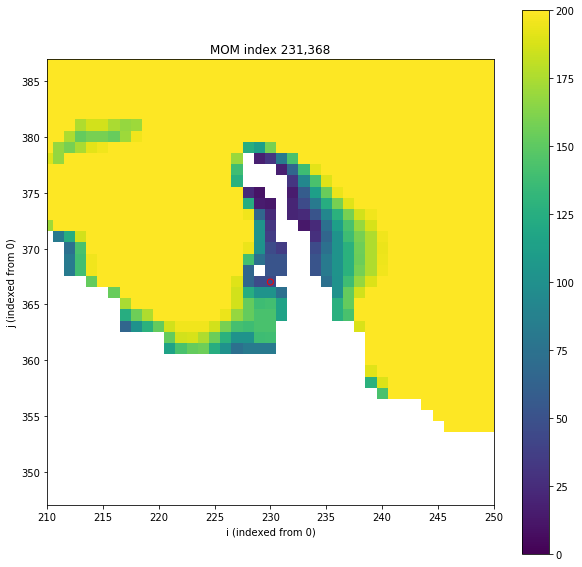

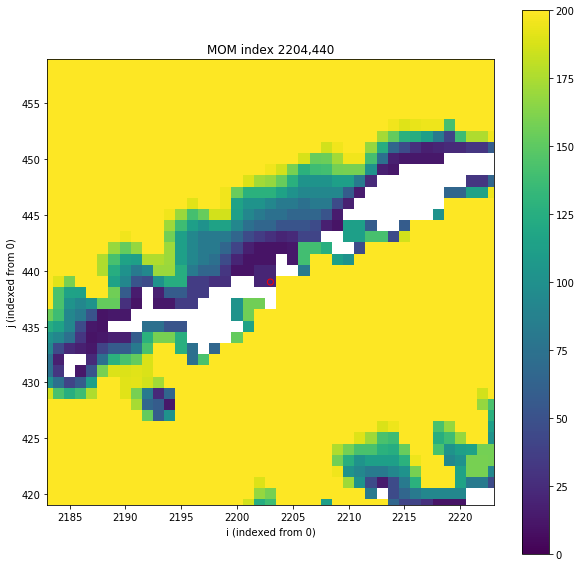

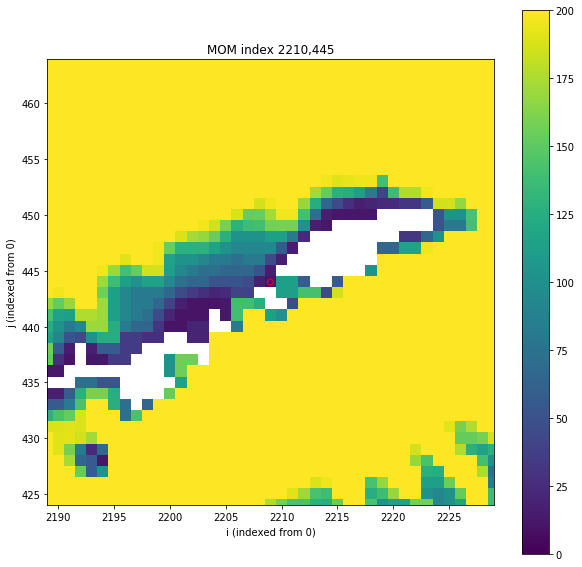

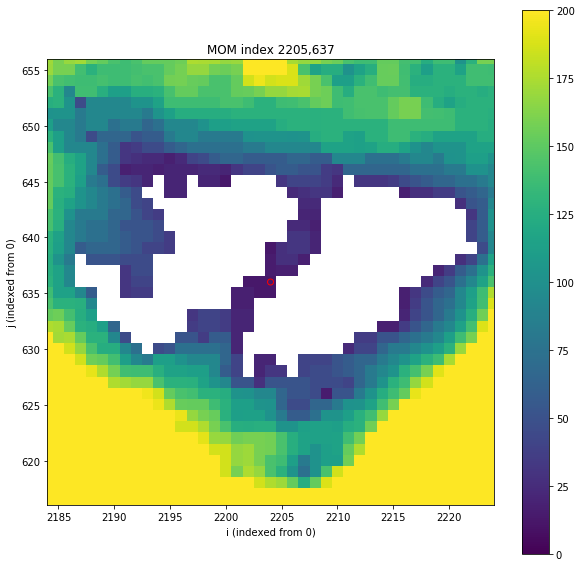

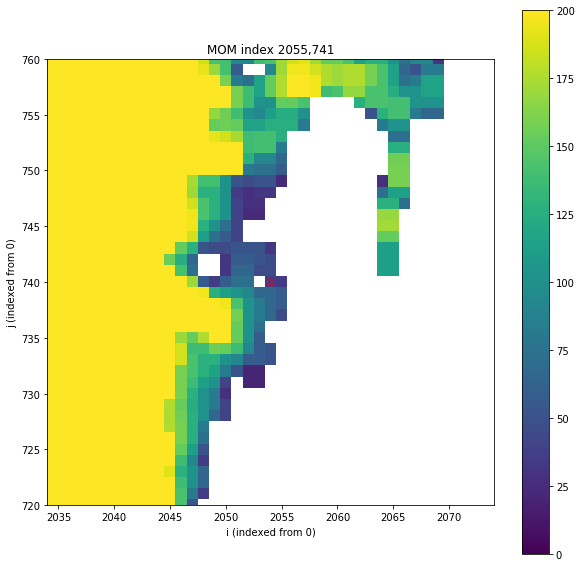

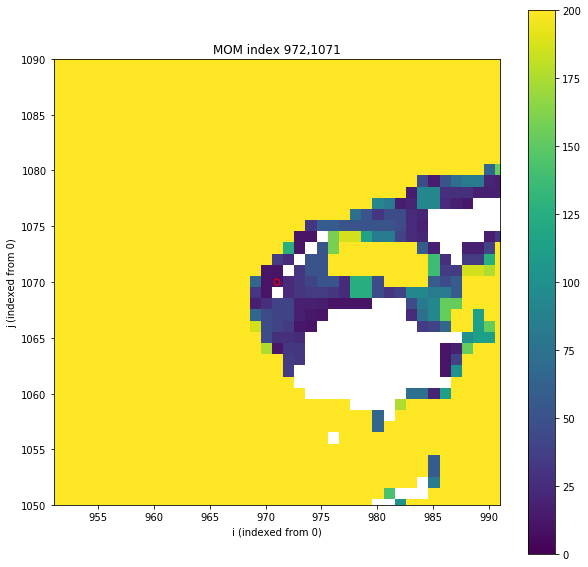

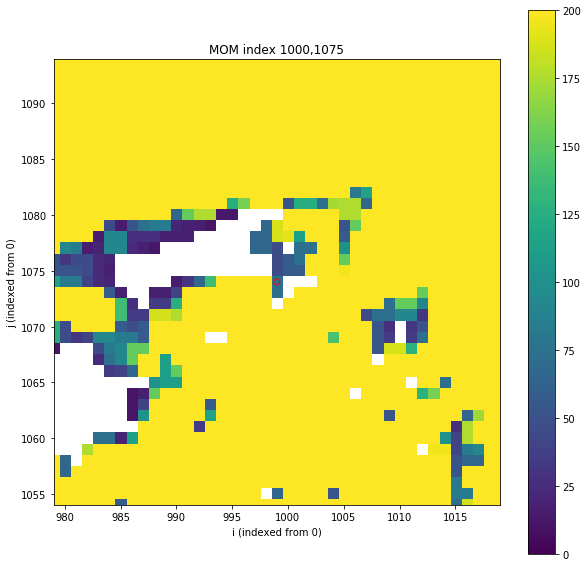

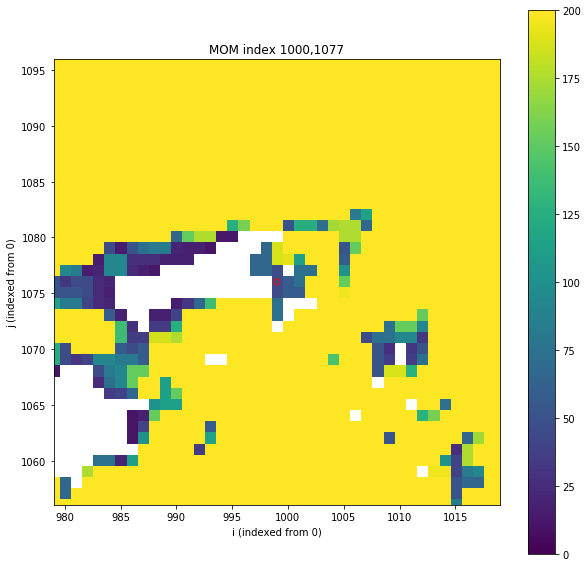

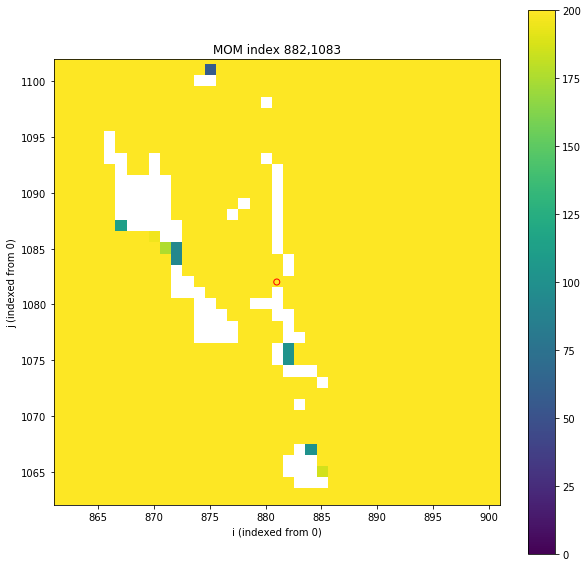

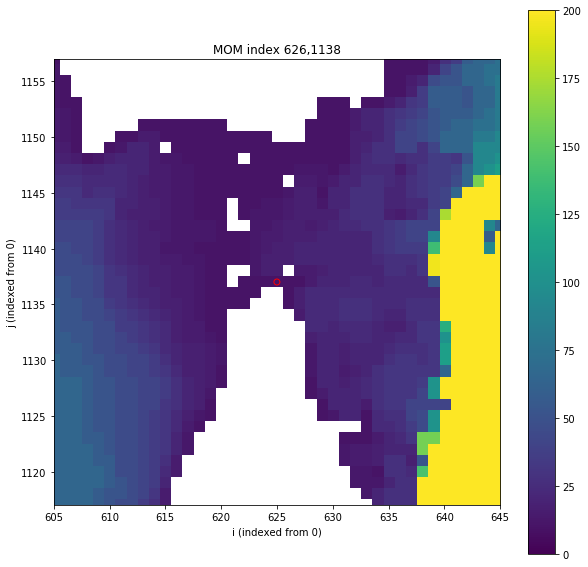

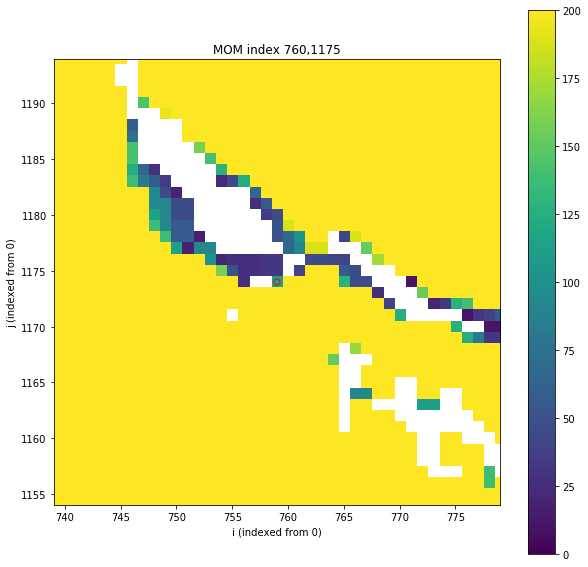

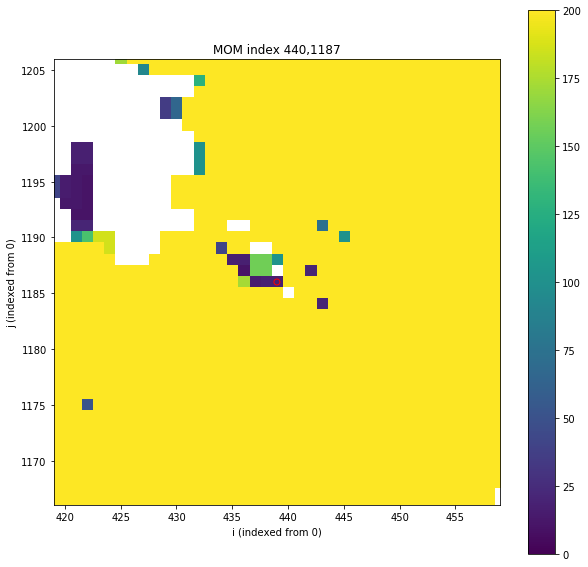

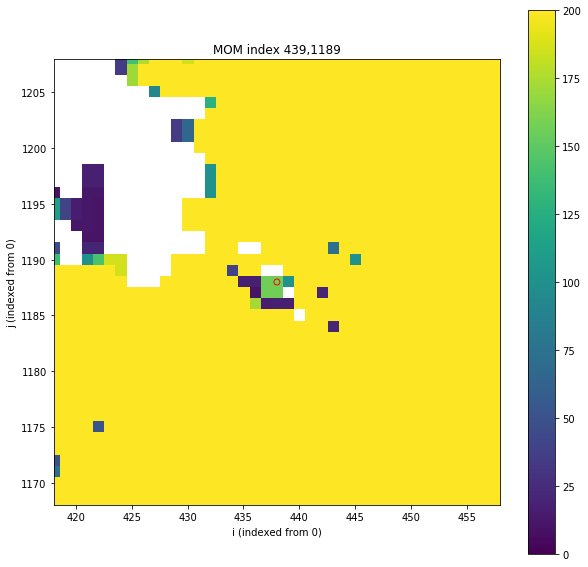

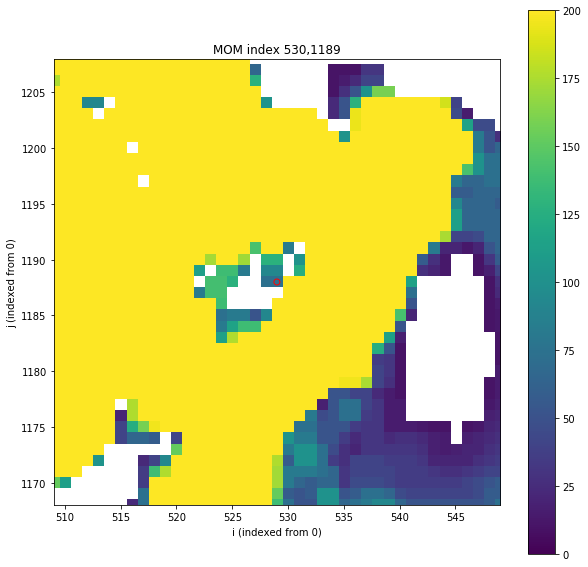

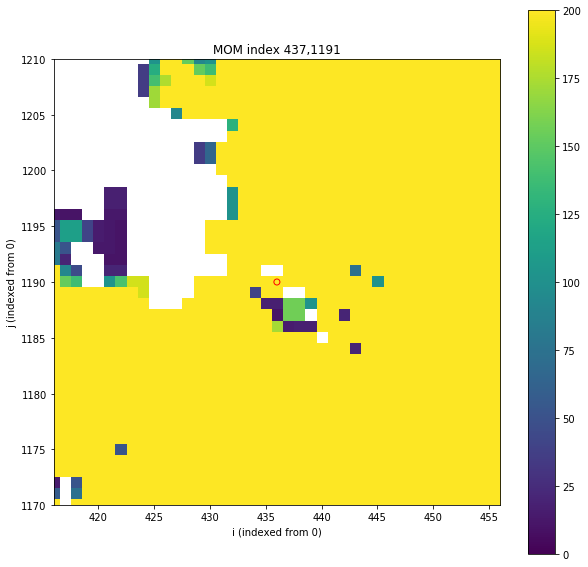

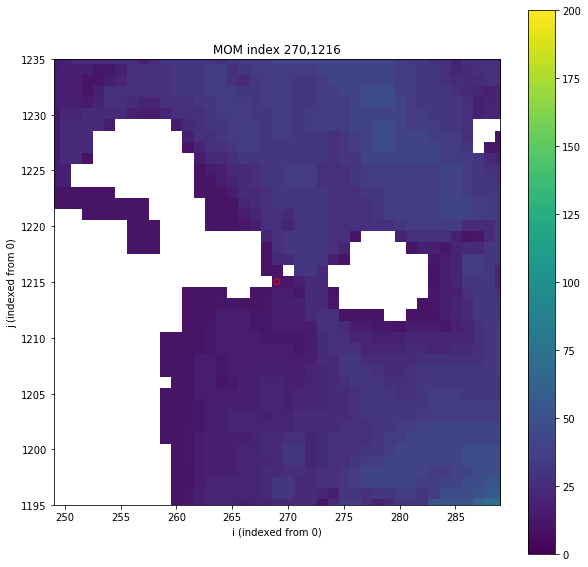

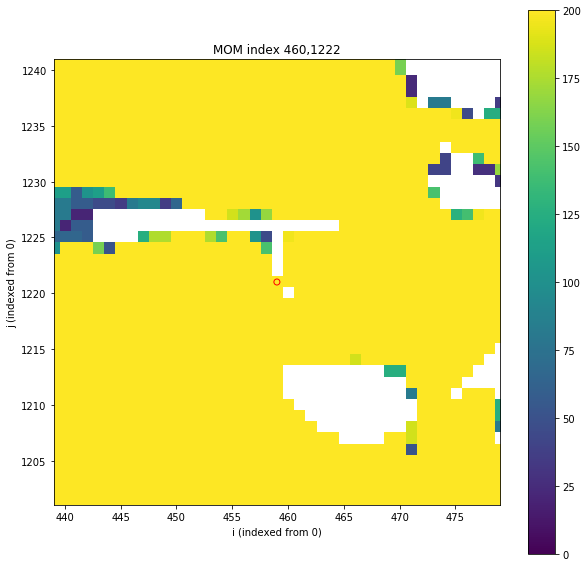

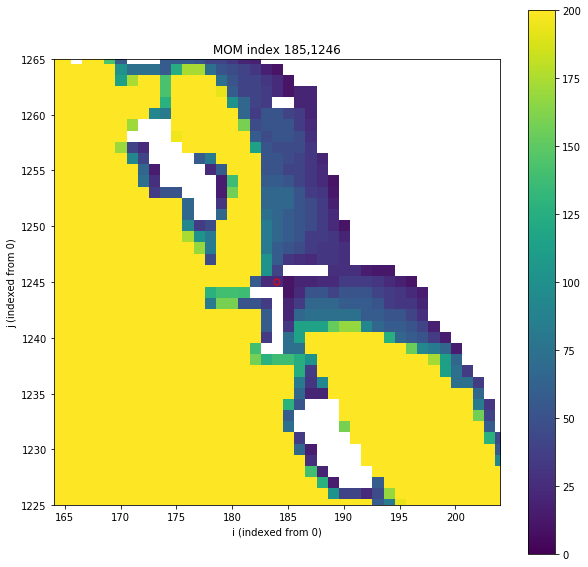

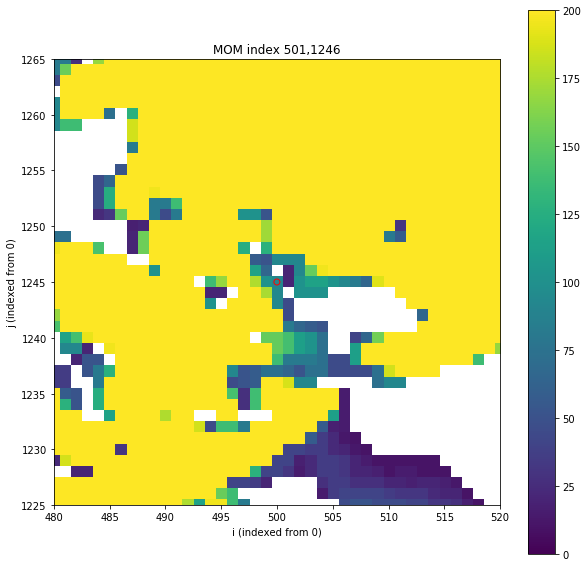

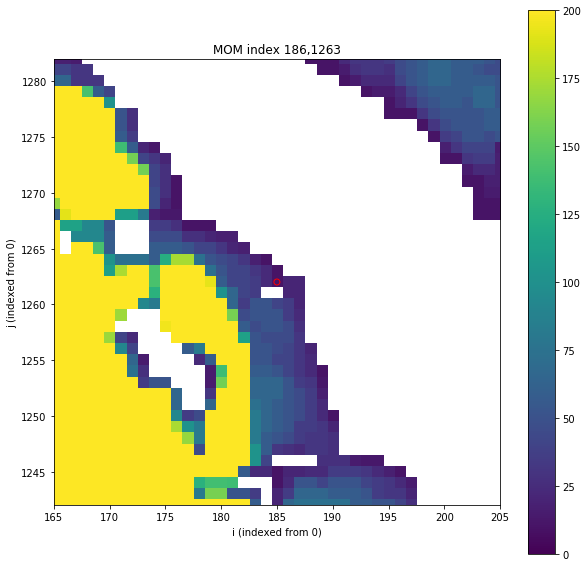

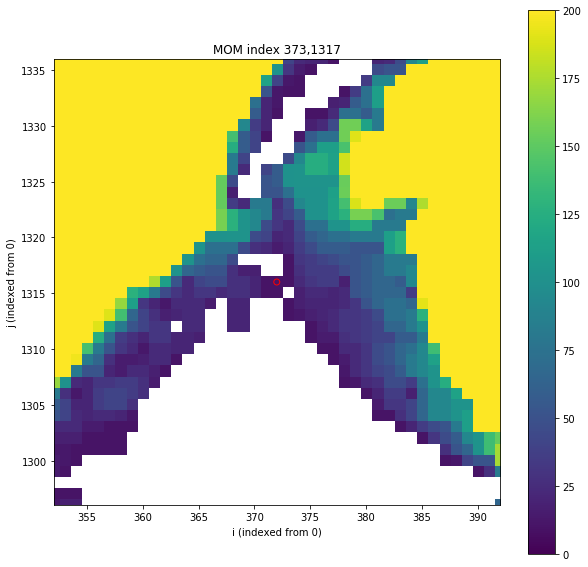

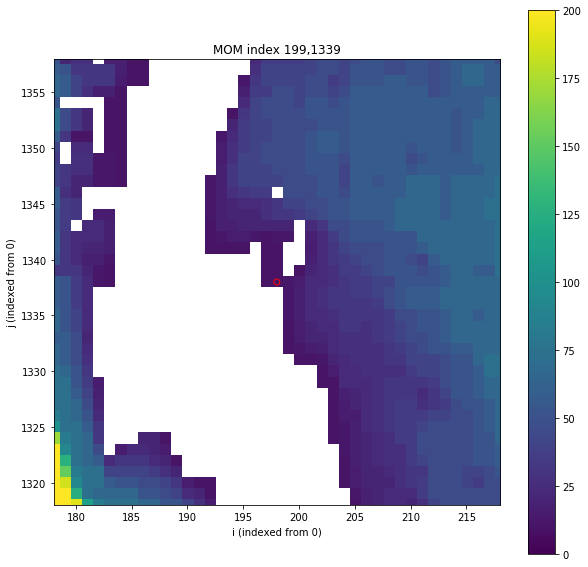

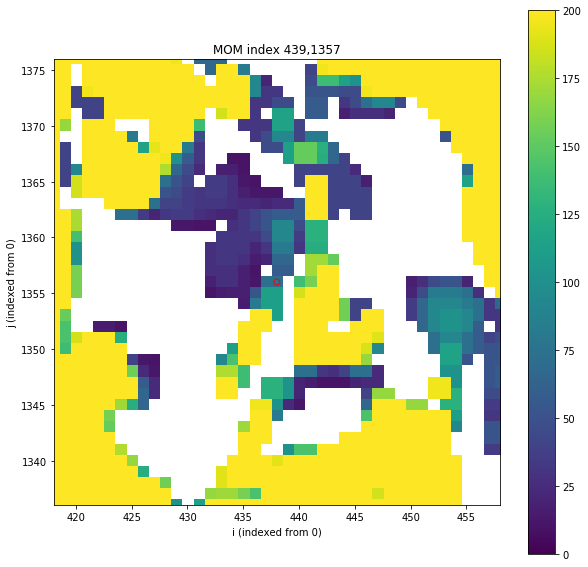

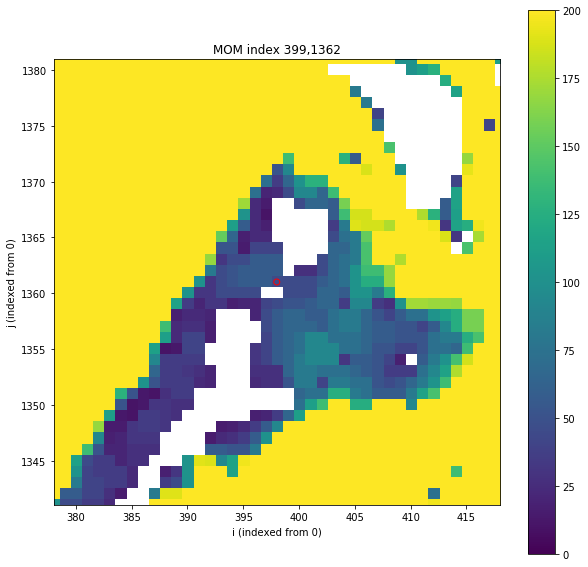

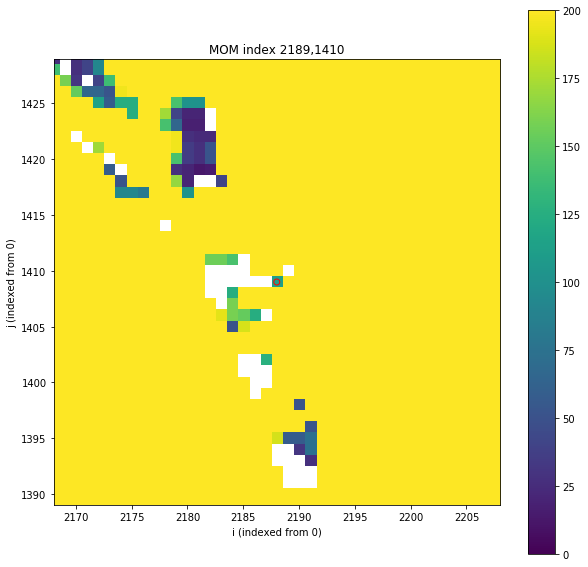

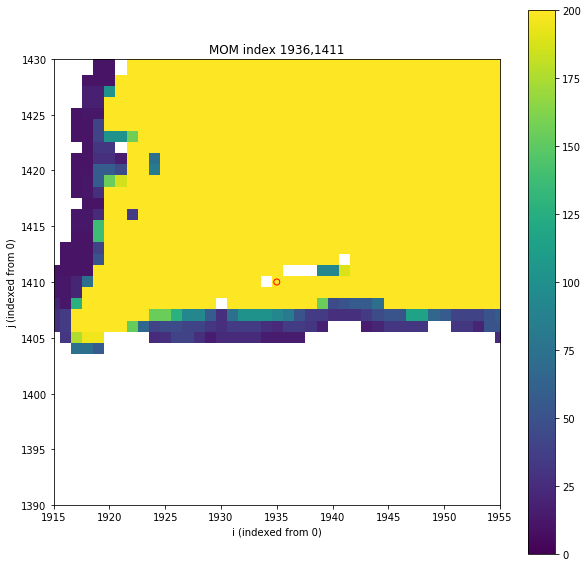

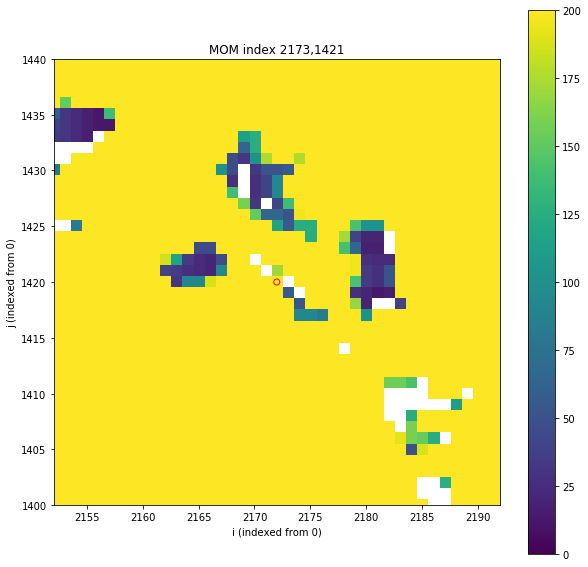

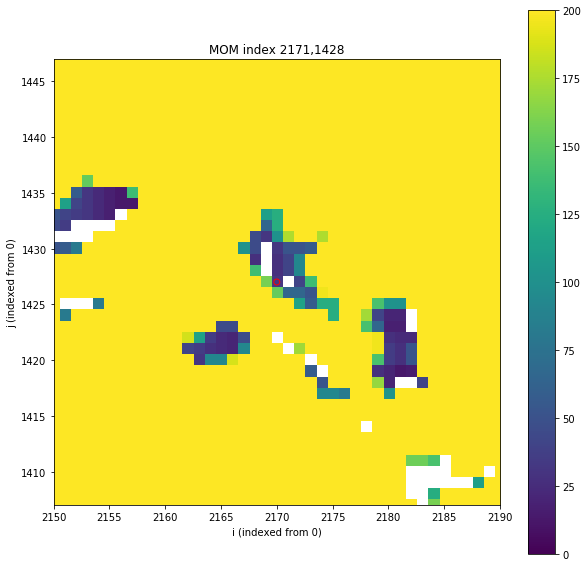

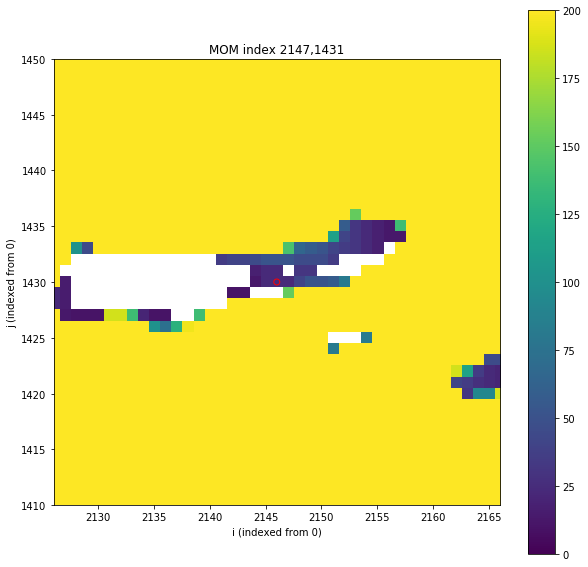

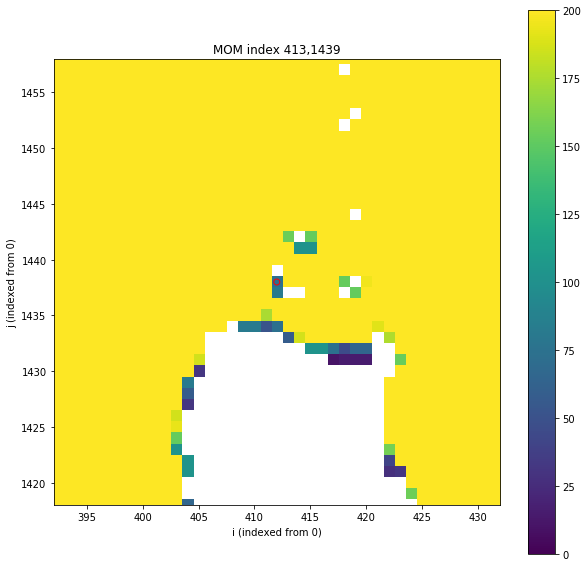

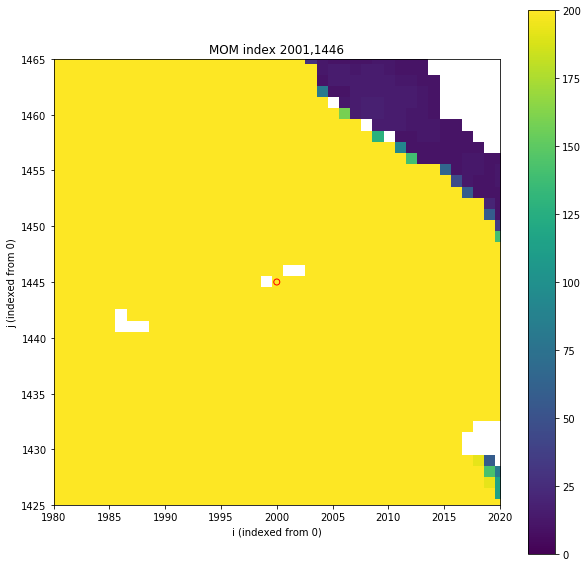

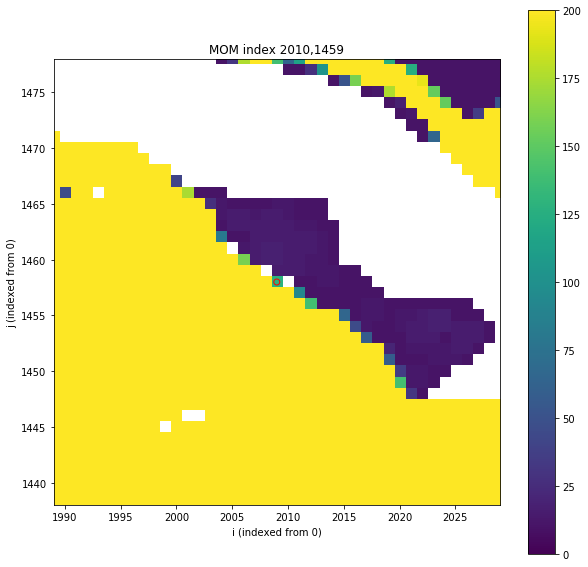

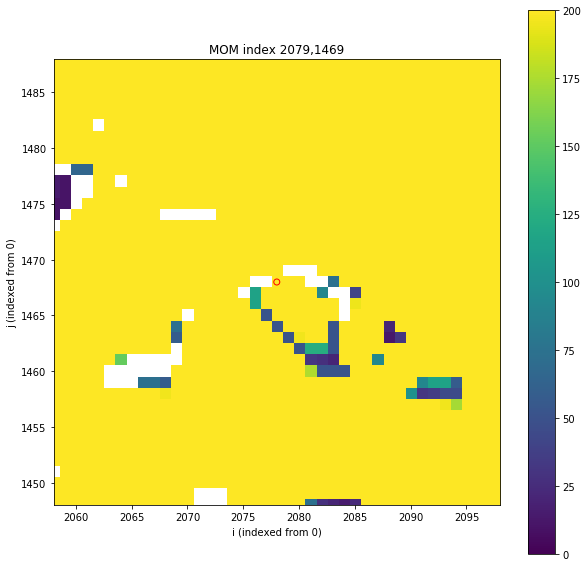

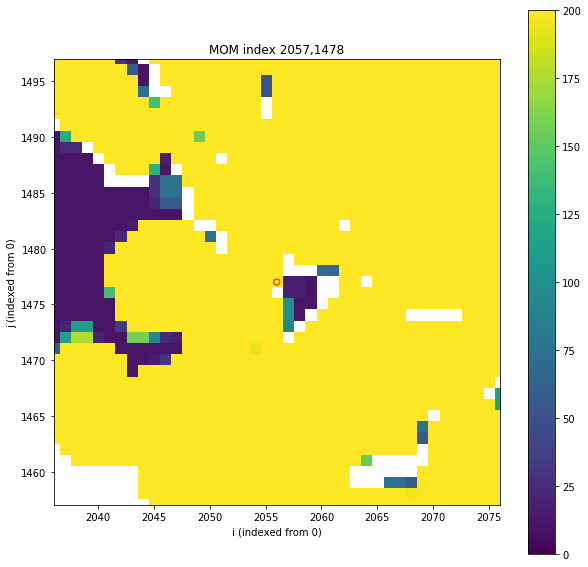

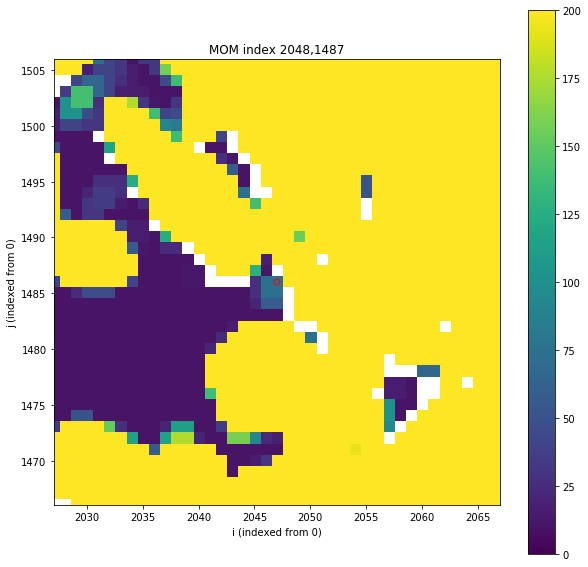

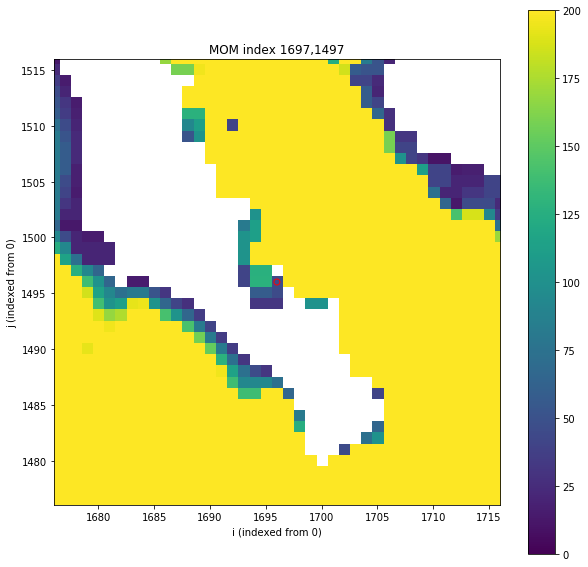

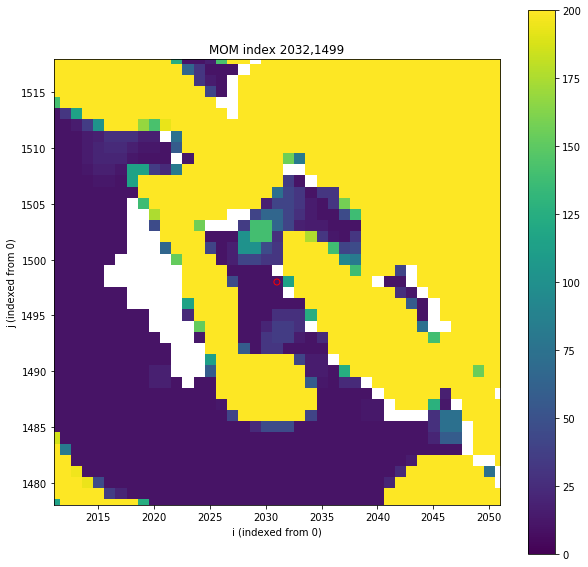

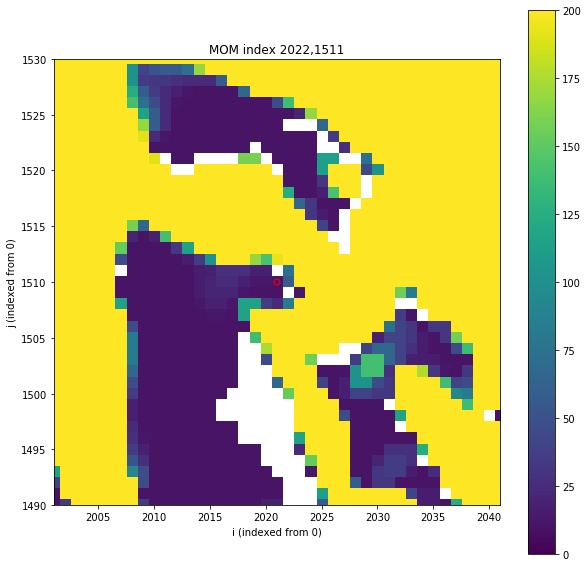

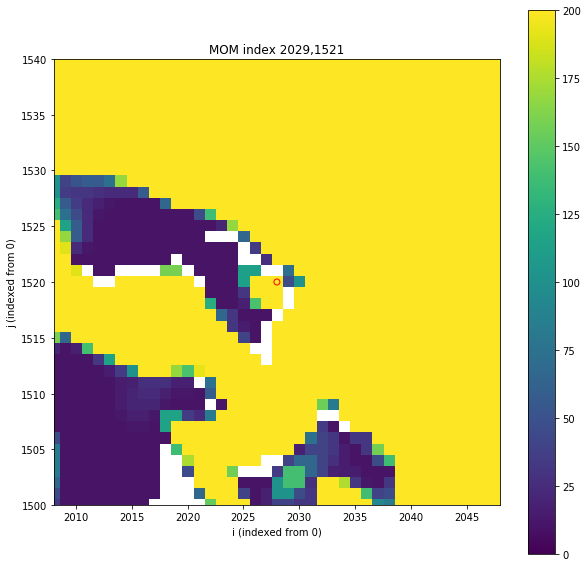

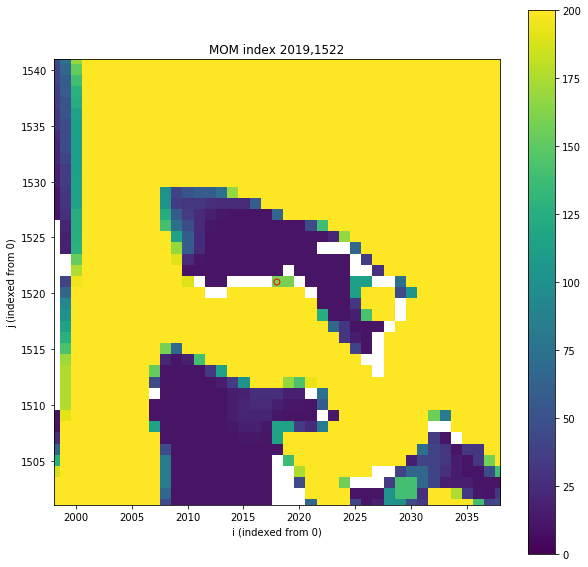

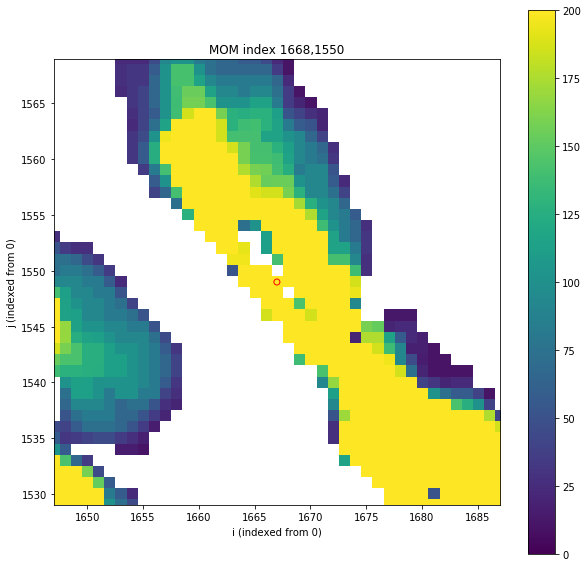

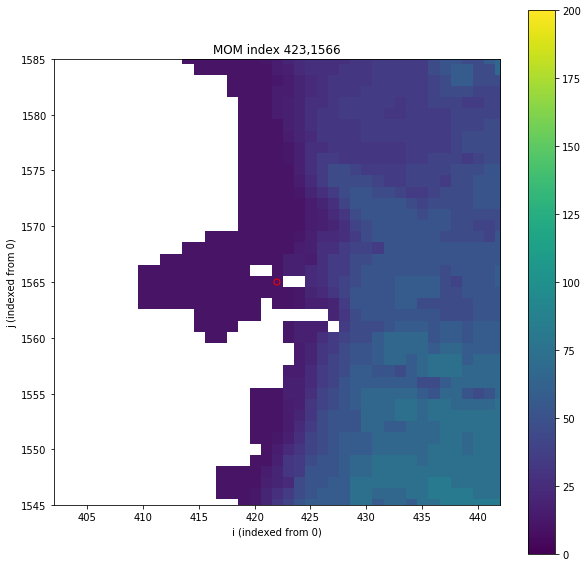

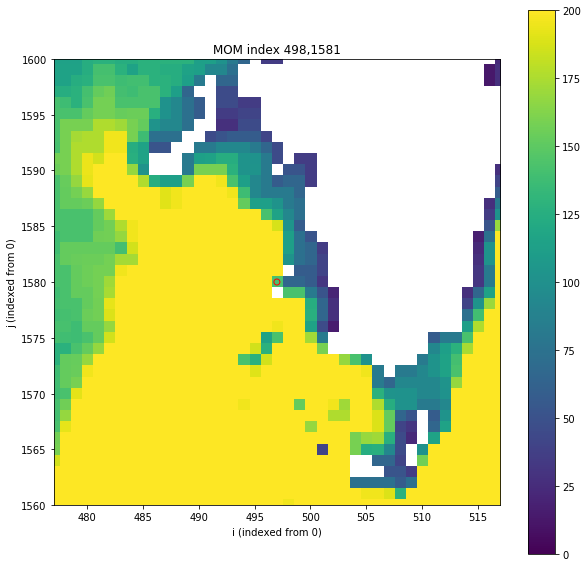

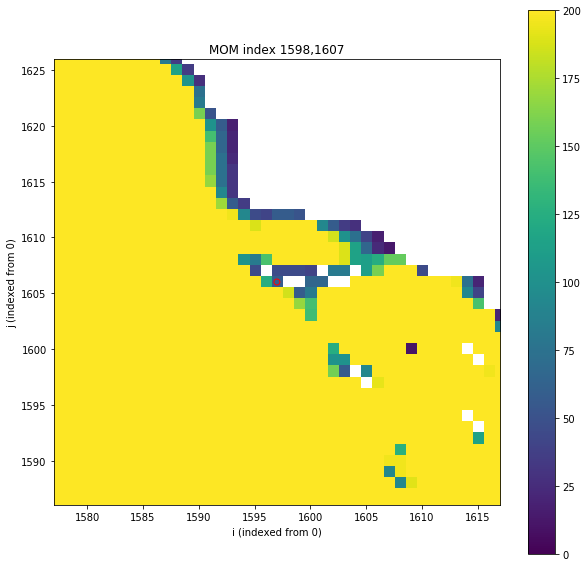

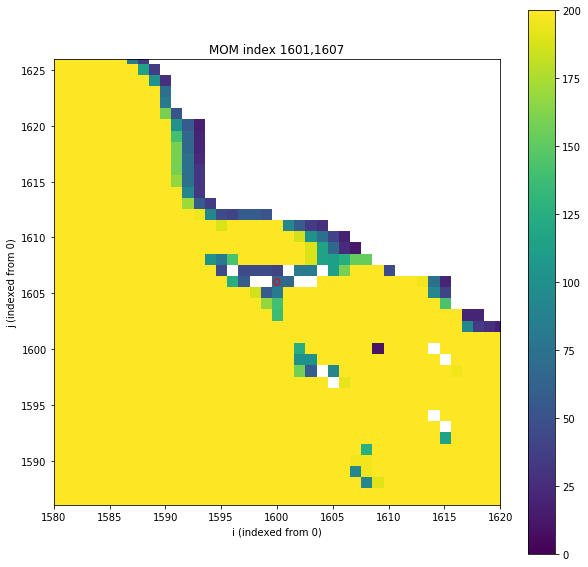

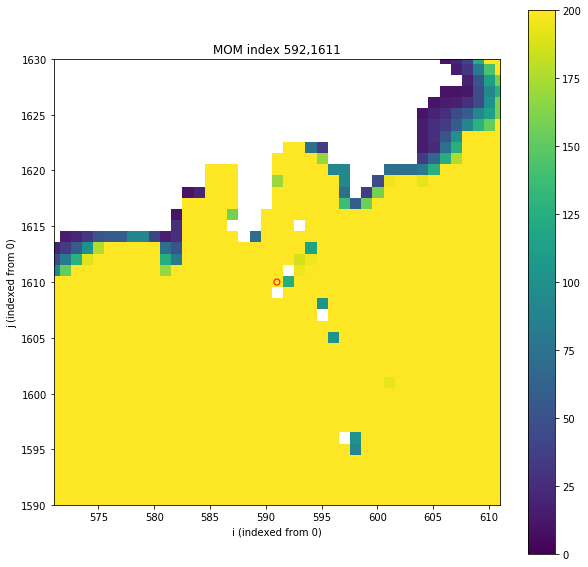

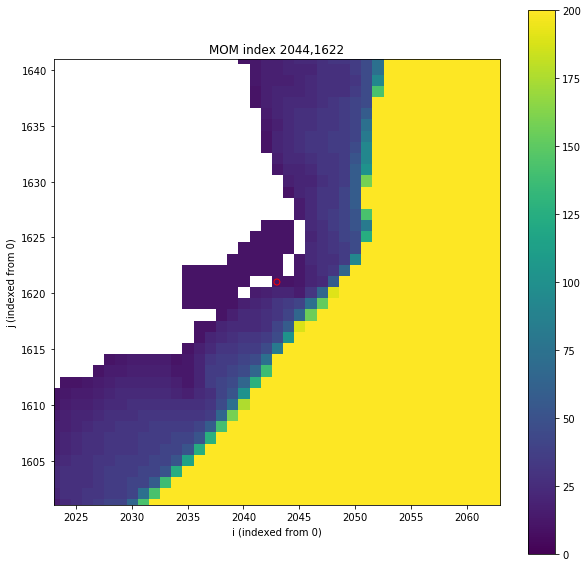

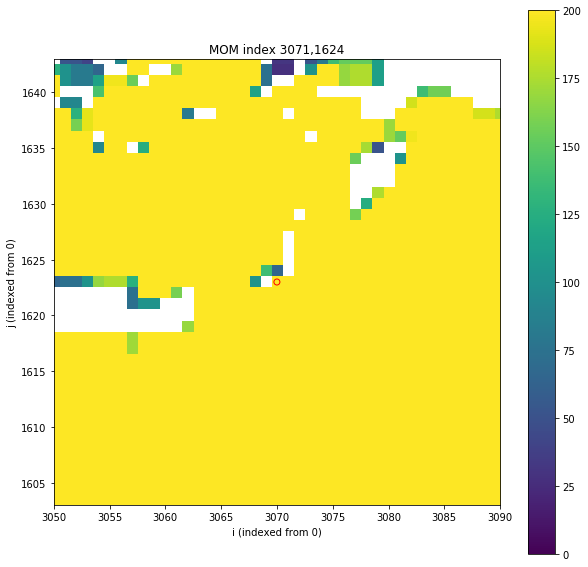

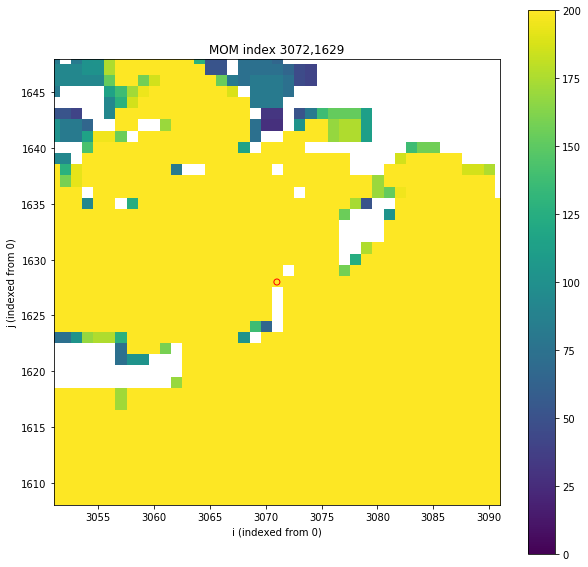

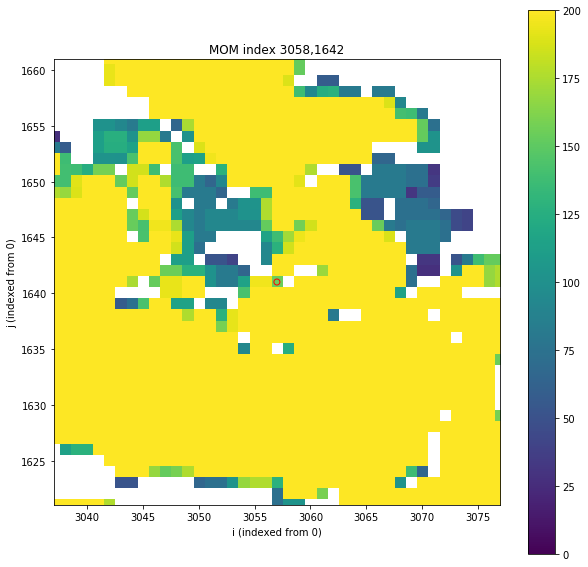

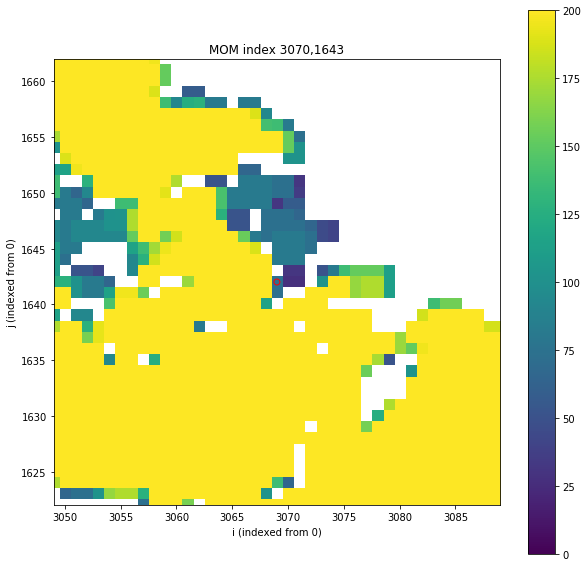

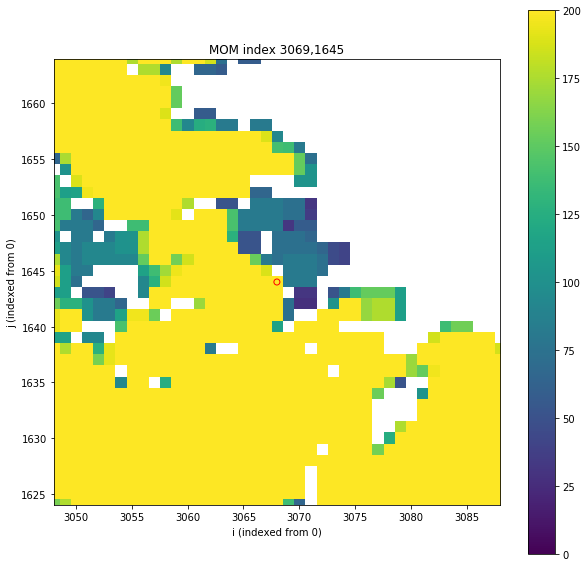

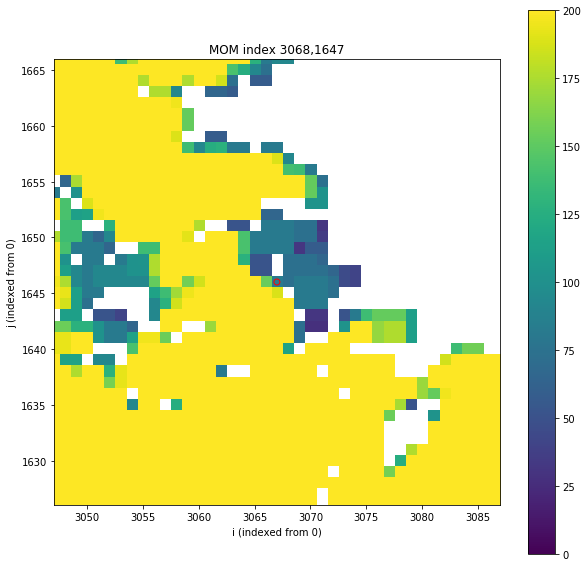

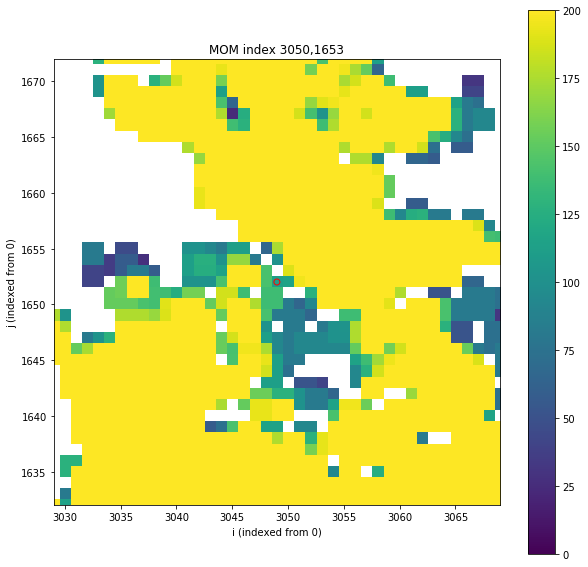

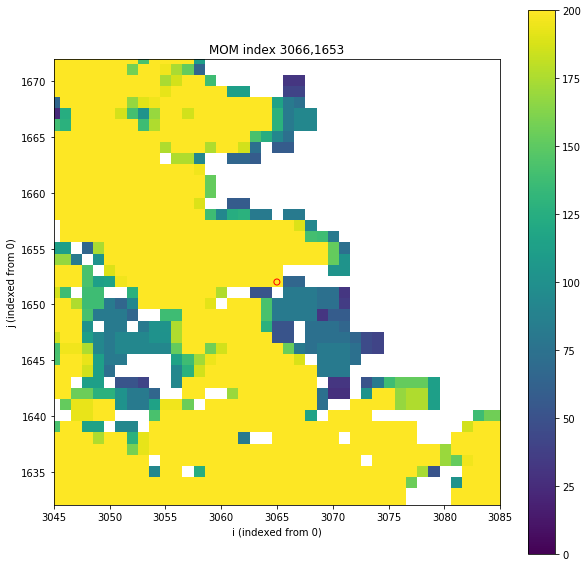

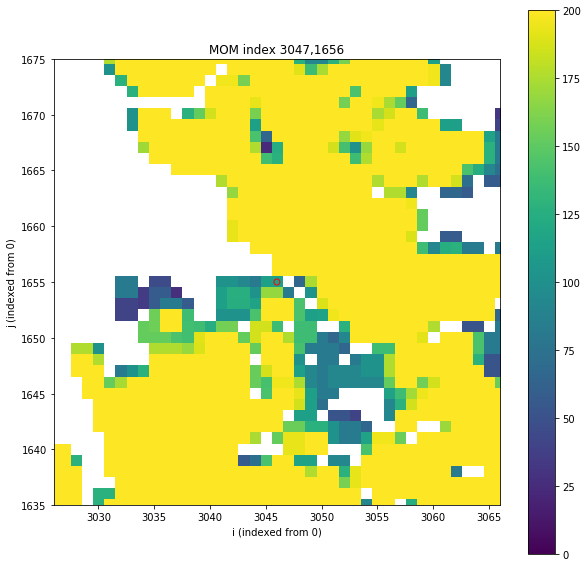

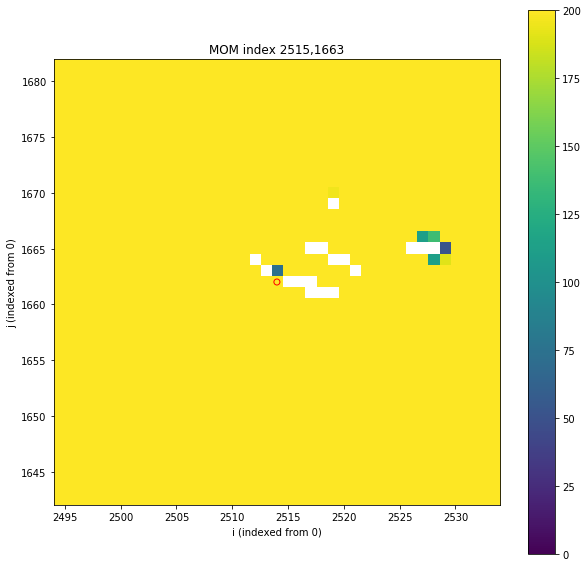

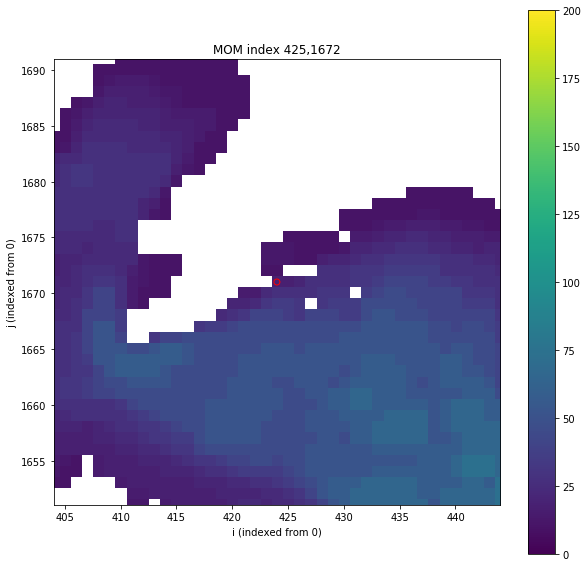

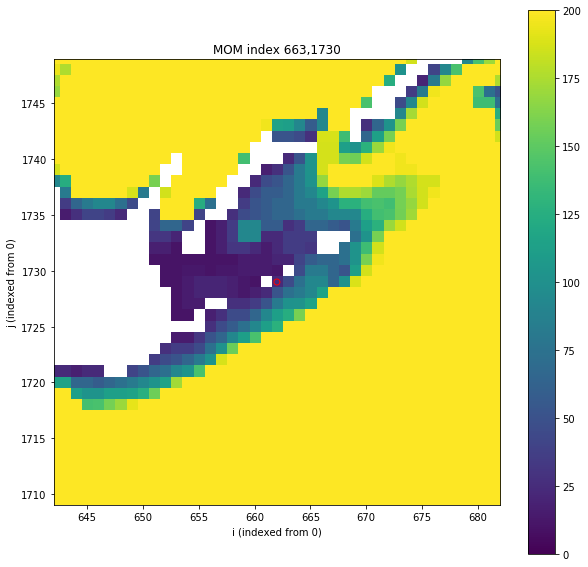

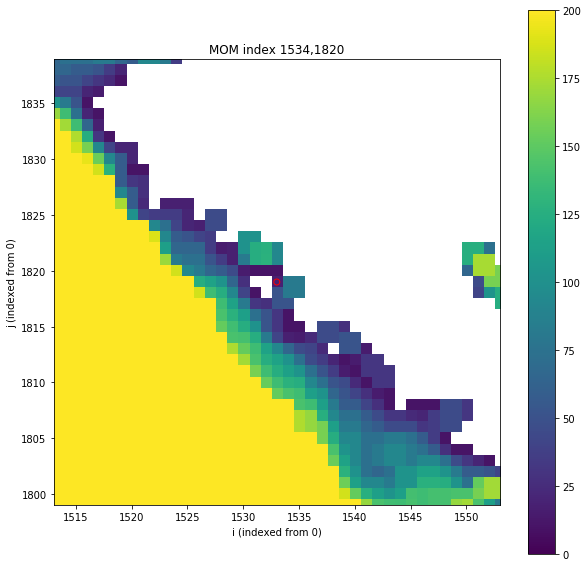

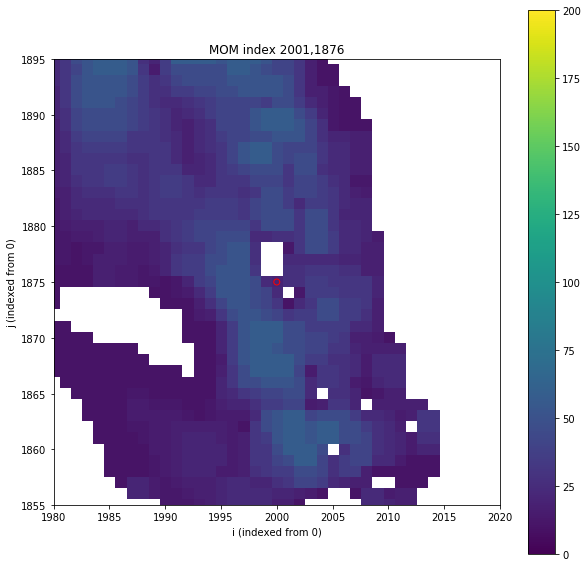

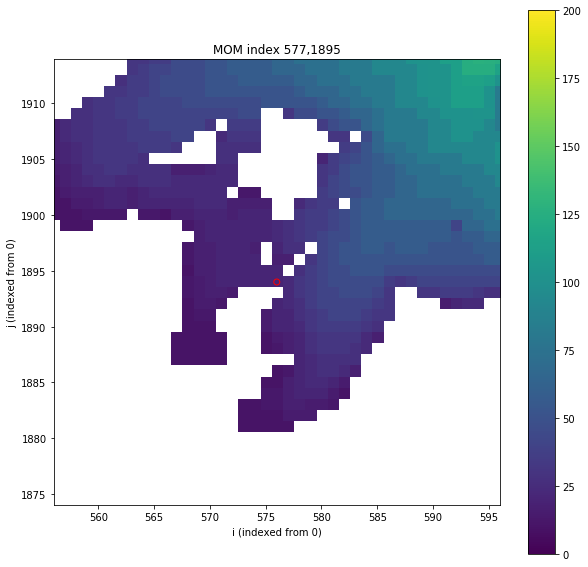

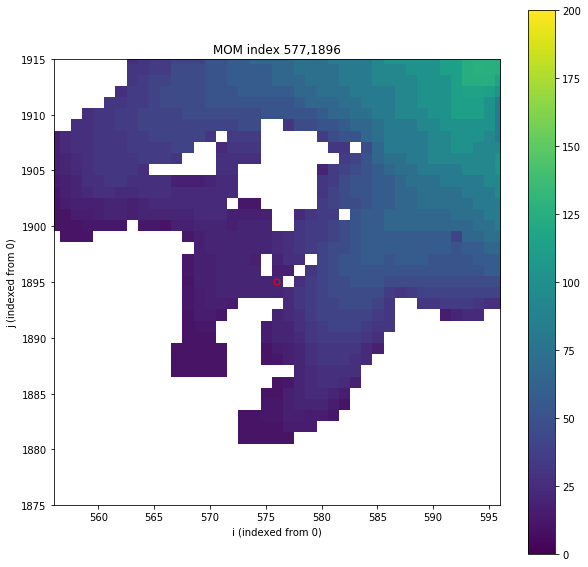

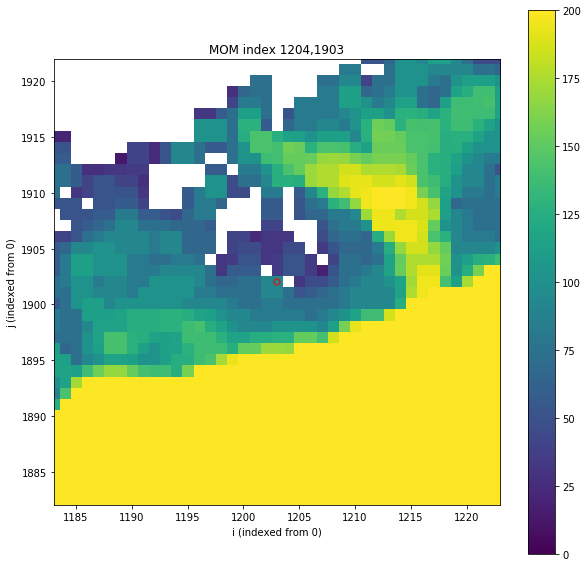

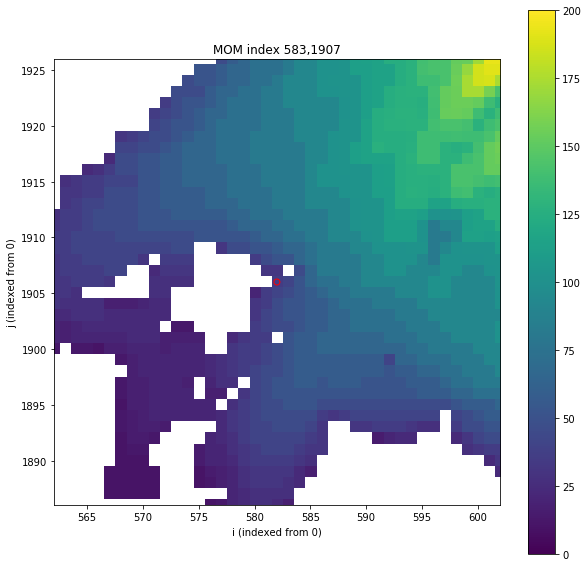

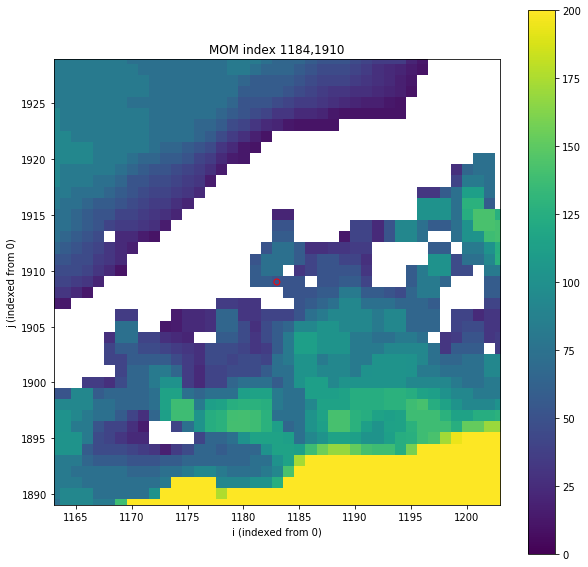

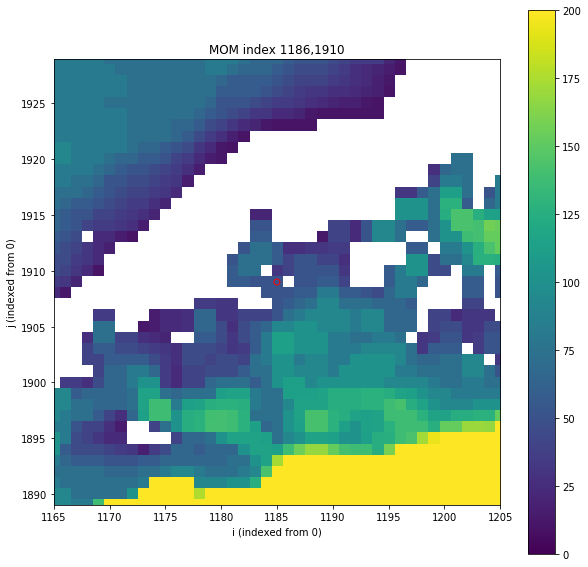

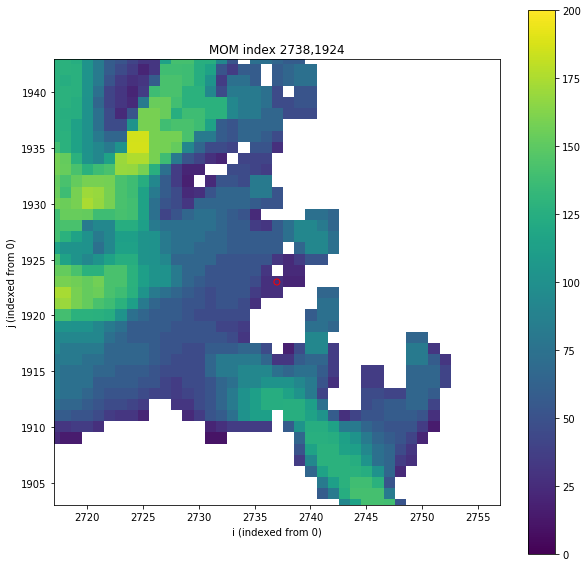

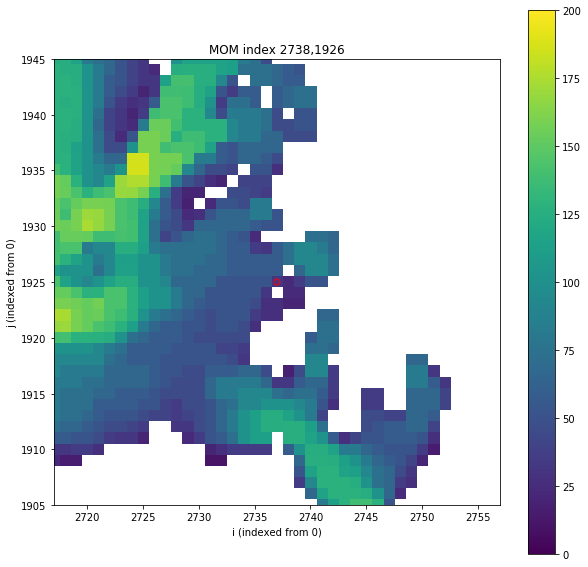

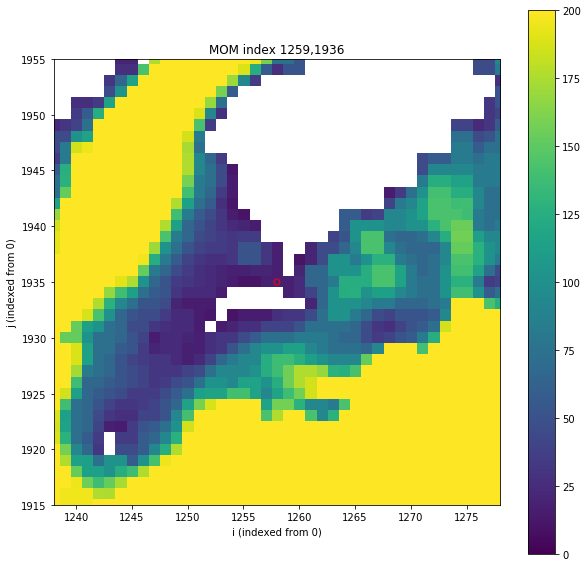

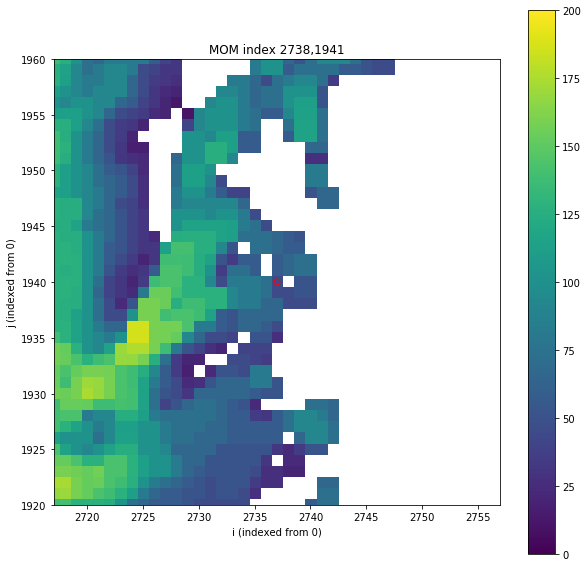

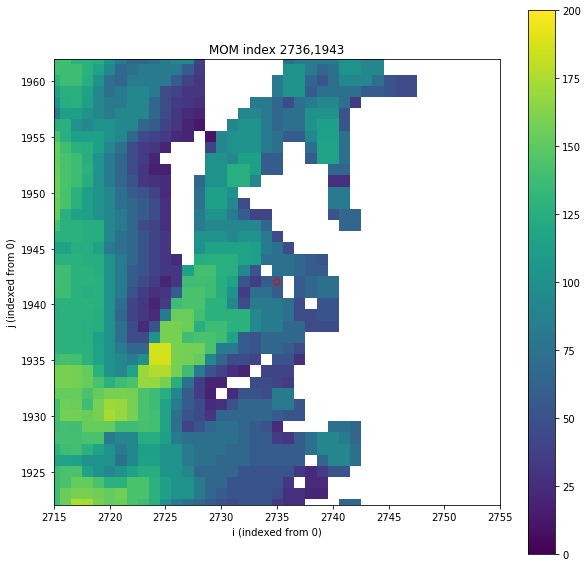

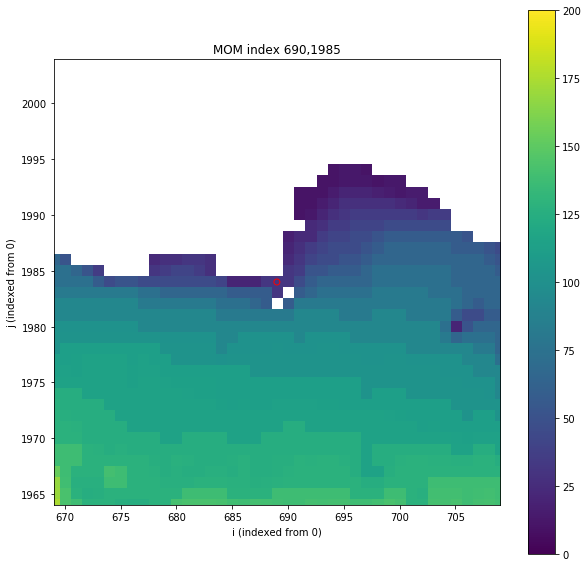

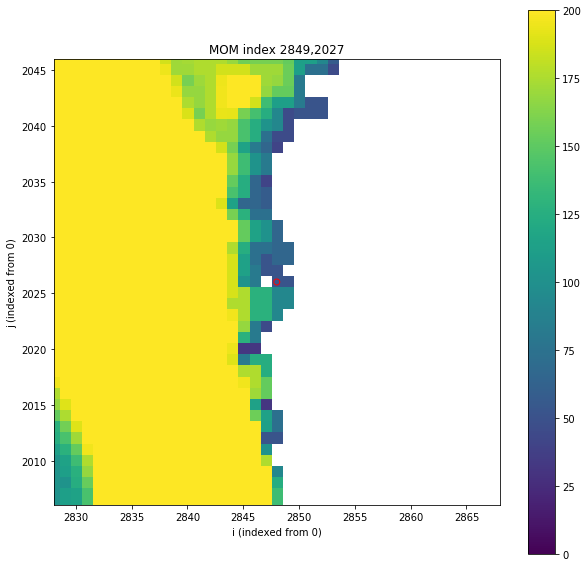

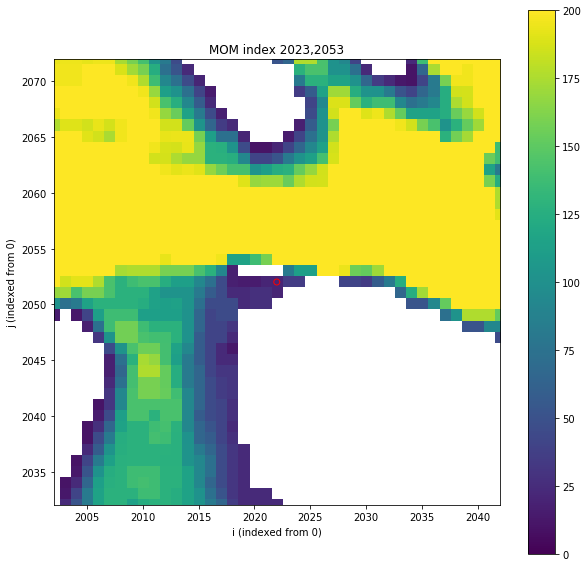

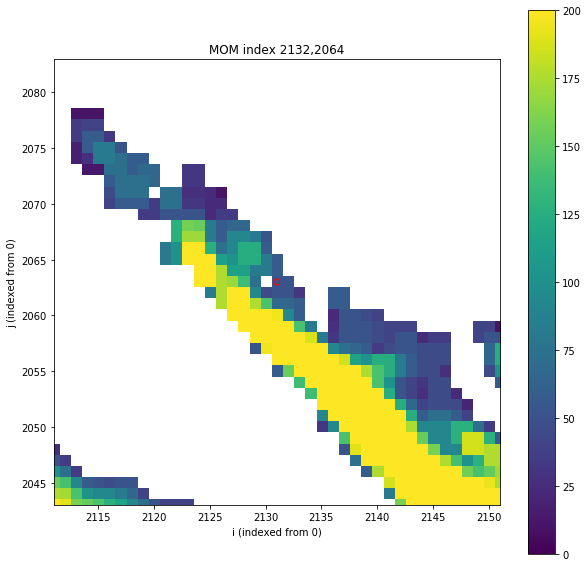

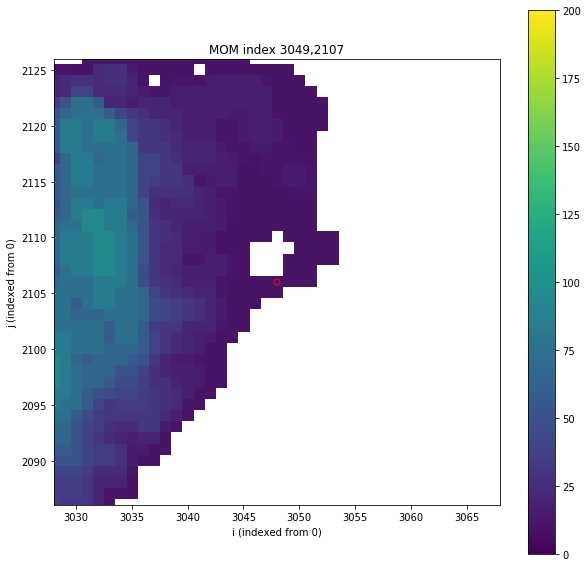

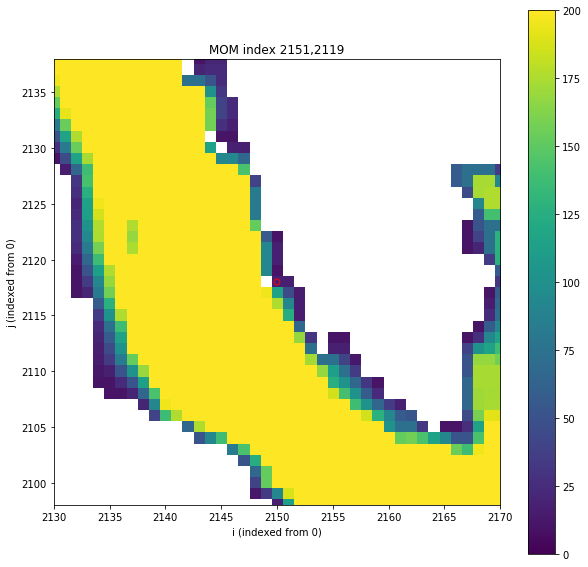

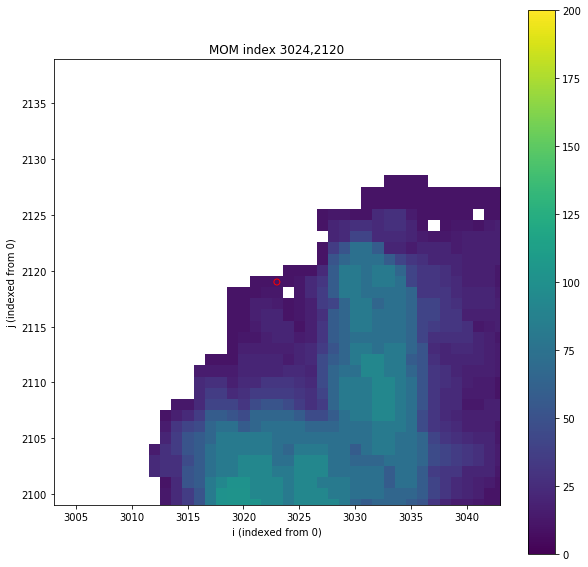

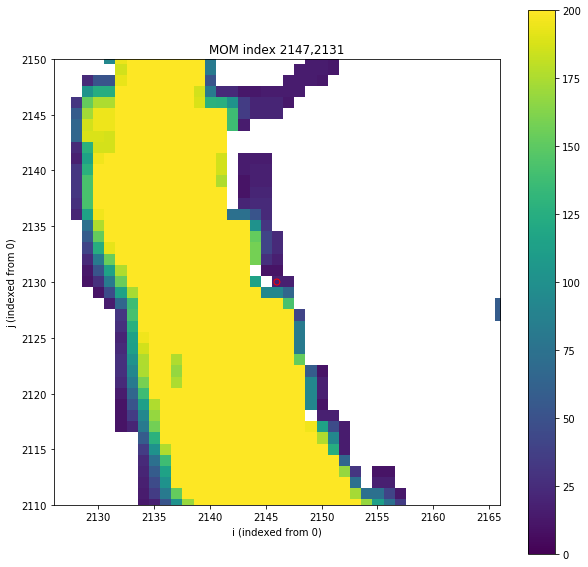

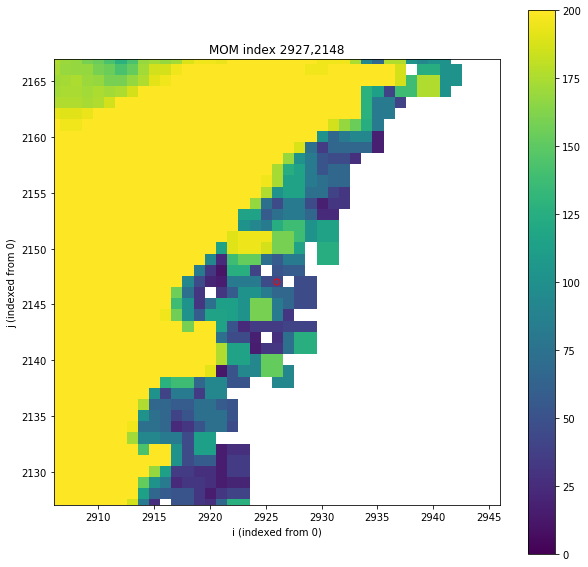

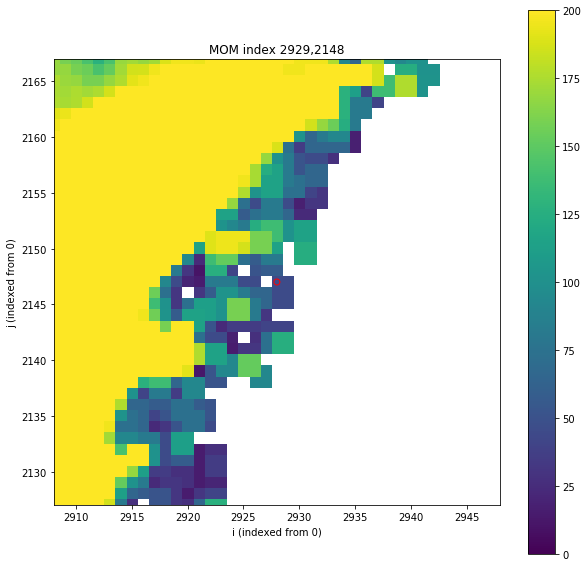

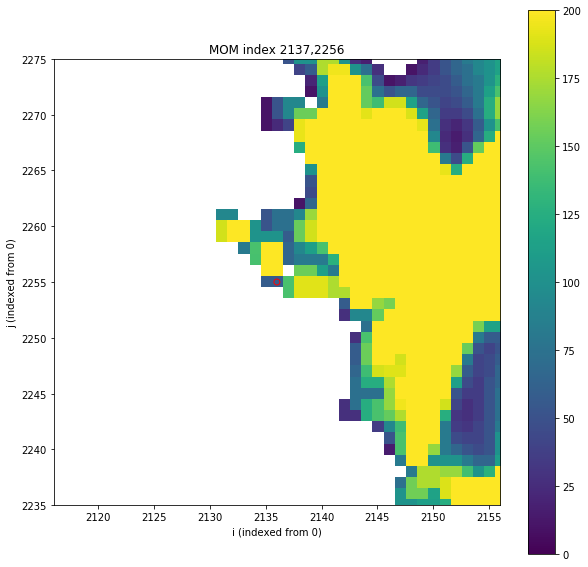

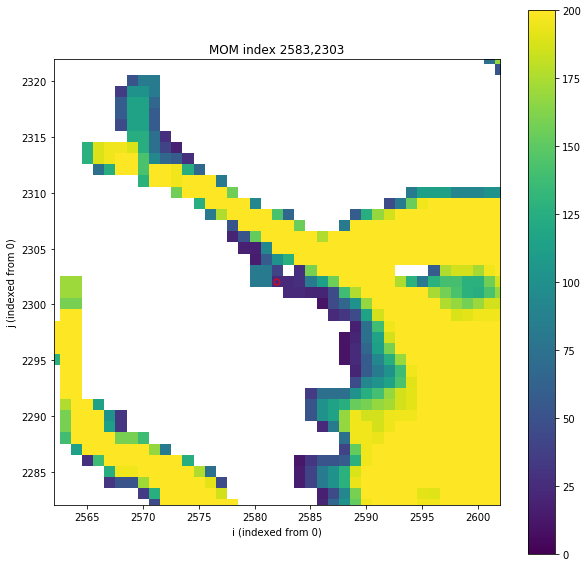

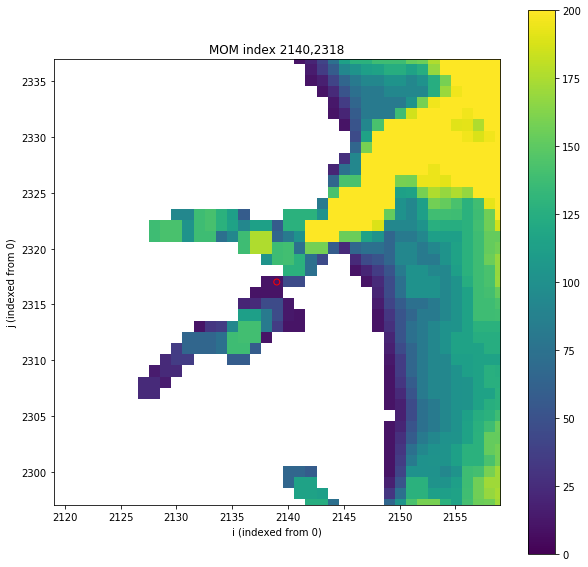

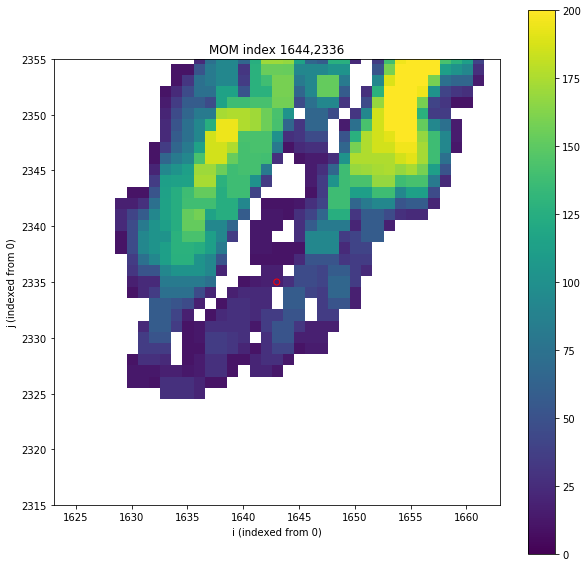

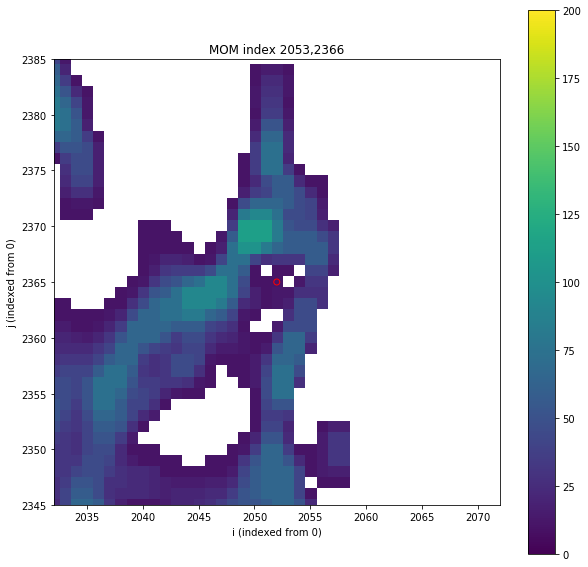

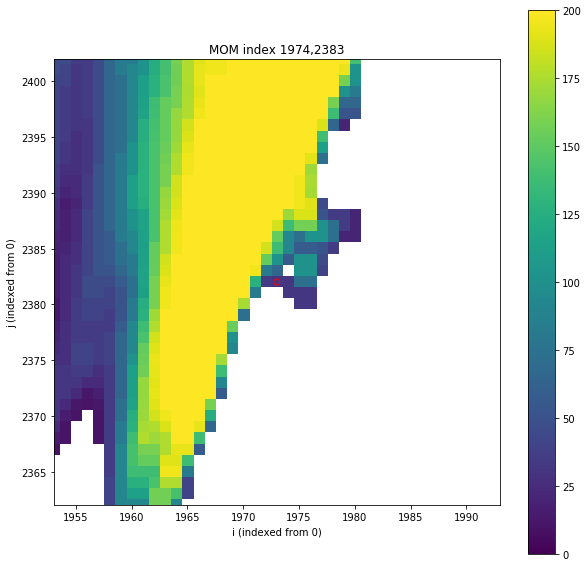

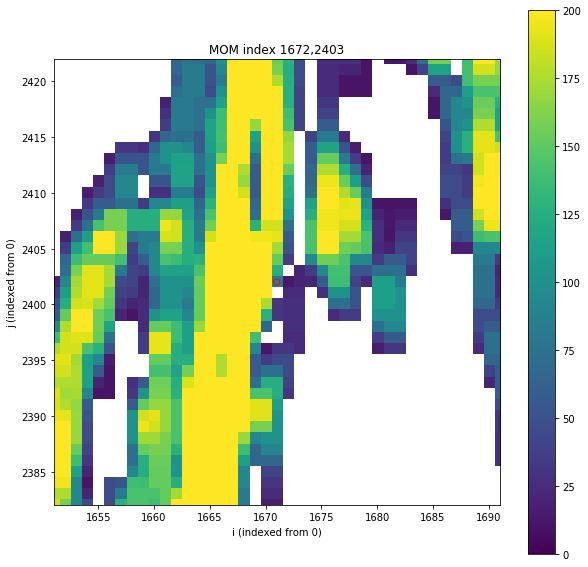

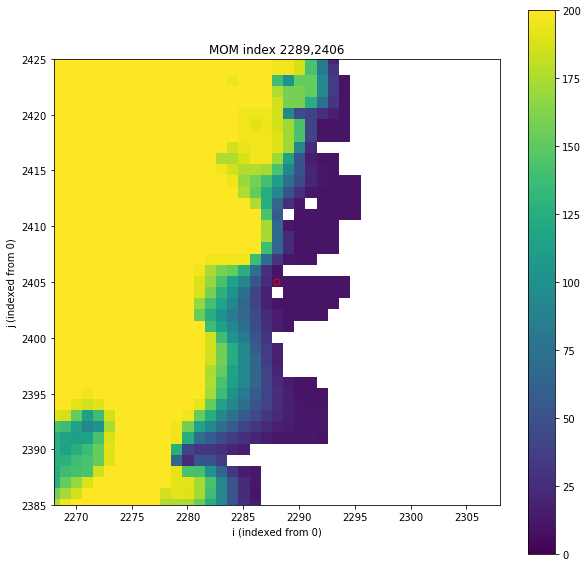

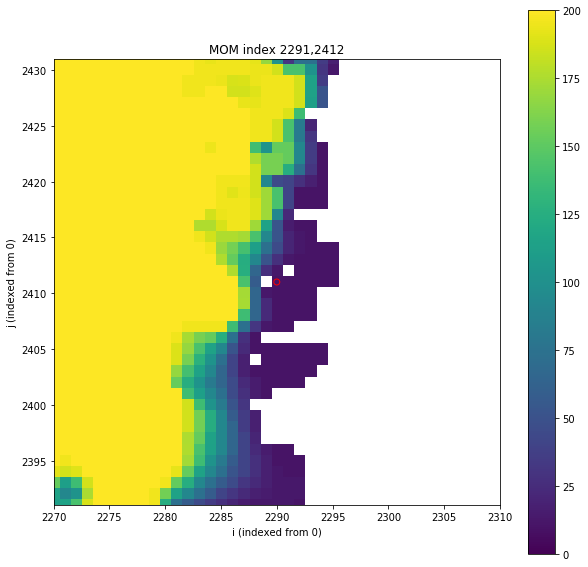

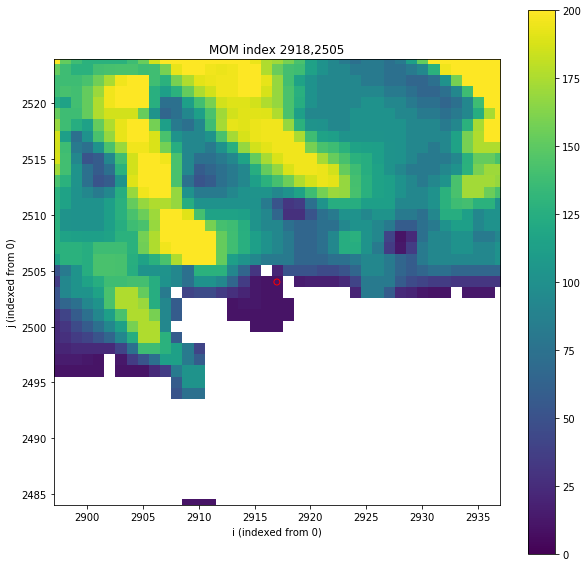

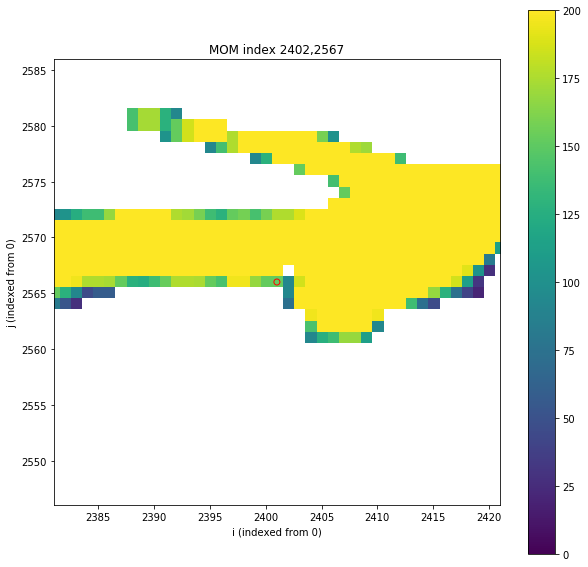

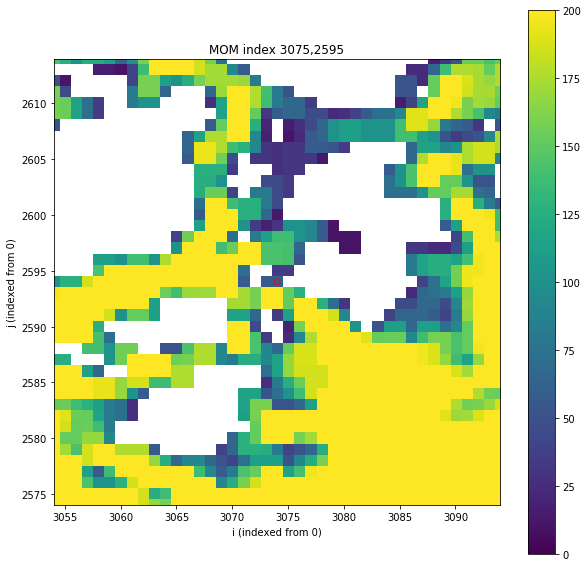

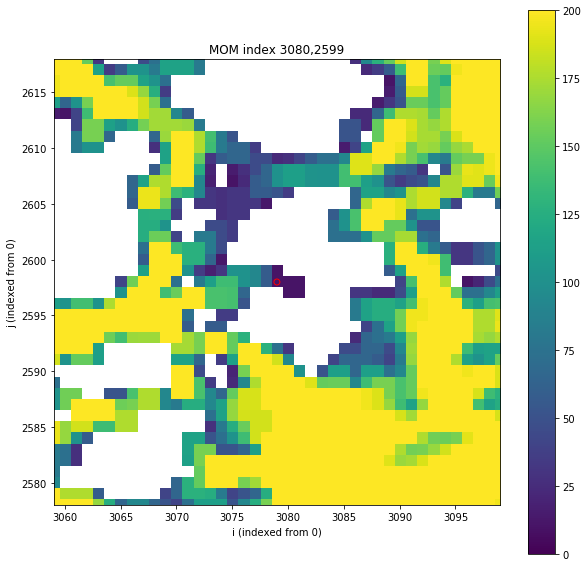

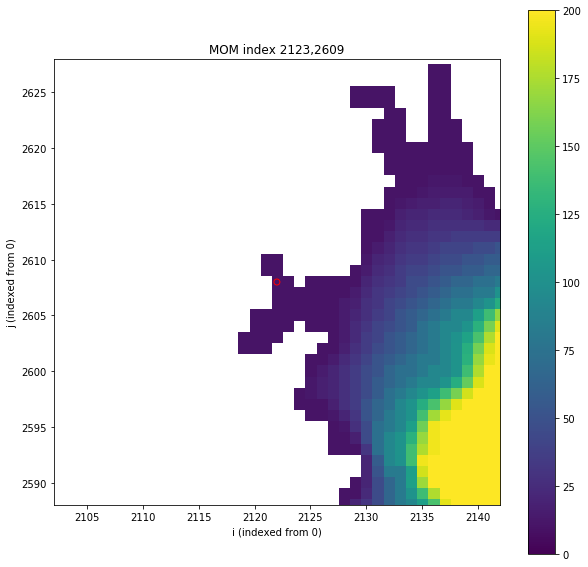

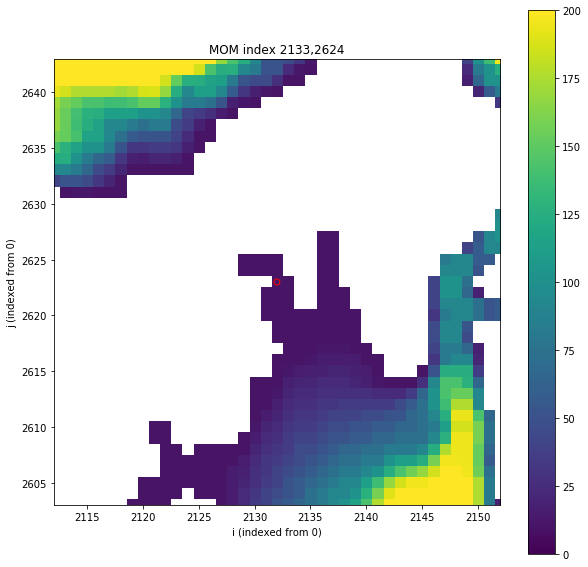

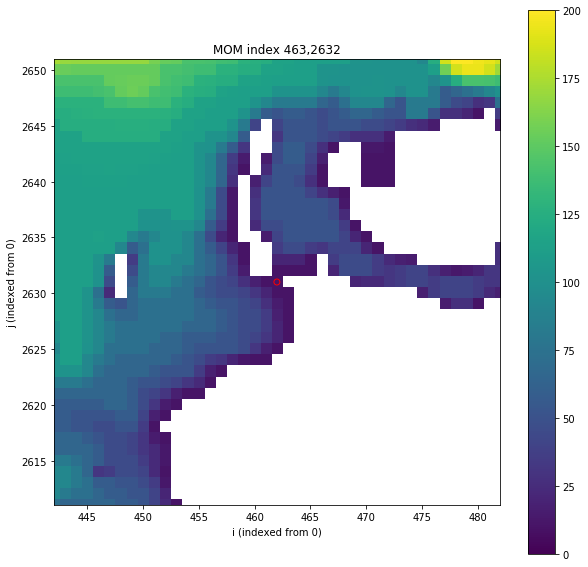

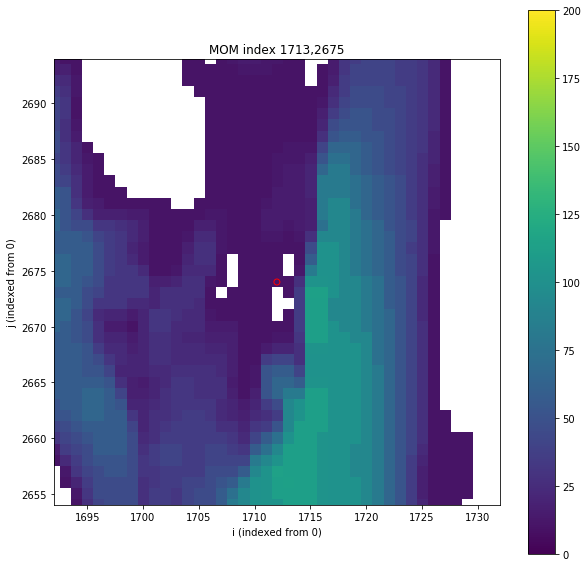

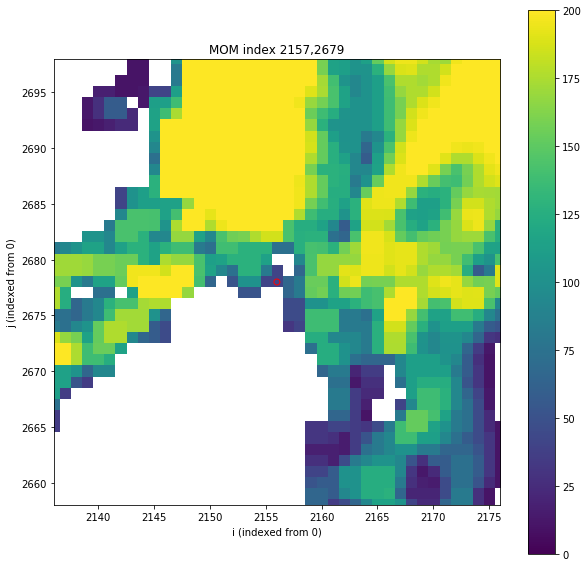

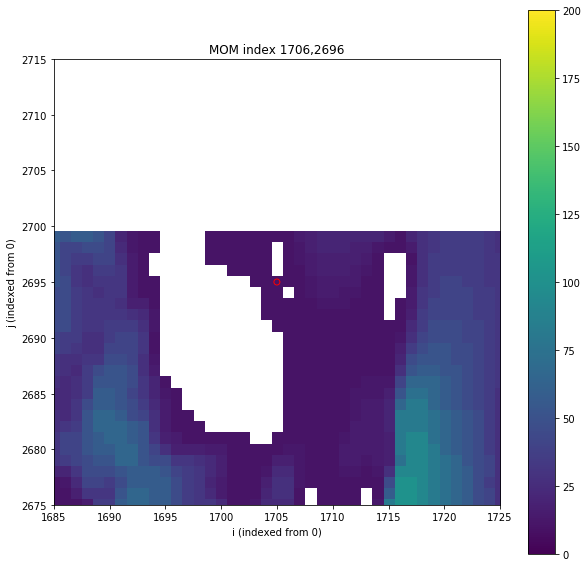

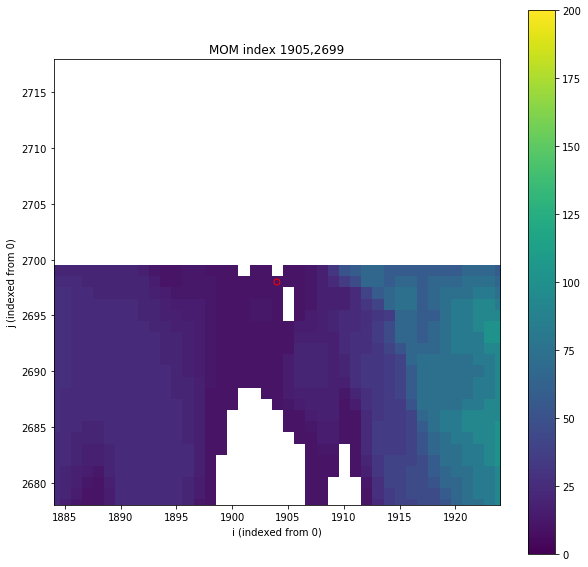

In [9]:
margin = 20
jj,ii=np.nonzero(noadv)
for k in range(len(ii)):
    i = ii[k]
    j = jj[k]
    plt.figure(figsize=(10,10))
    plt.imshow(depth, vmin=0, vmax=200, origin='lower')
    plt.colorbar()
    plt.scatter(i,j, facecolors='none', edgecolors='r')
    plt.xlim(i-margin,i+margin)
    plt.ylim(j-margin,j+margin)
    plt.title(fixedbathyfile)
    plt.title('MOM index '+str(i+1)+','+str(j+1))
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)');
